## Setup, Loading Data and CDFs

In [2]:
DATA_NAME = 'approx1e5-pastis-fourier-blue' # Dataset Format: size-name-transform-channel

In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/fourier/approx1e5/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

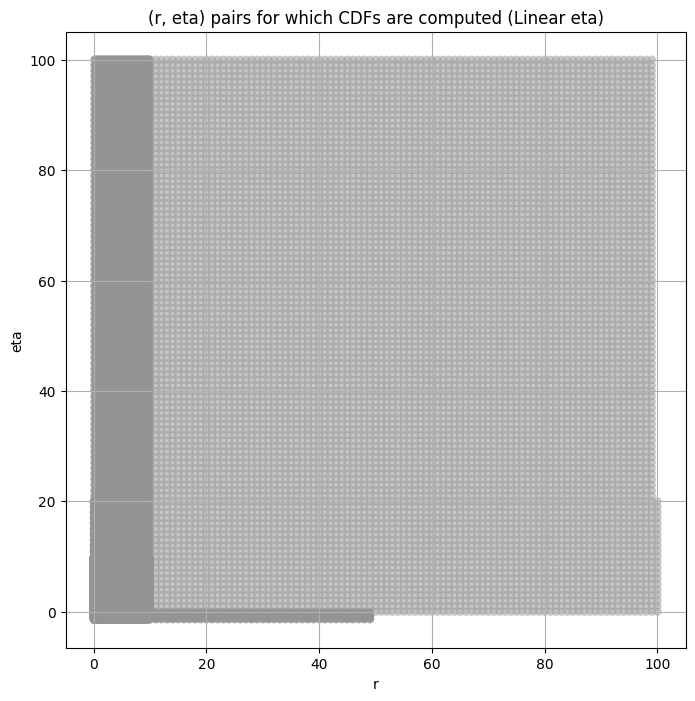

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [6]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [7]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [8]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:38<00:00, 2580.24it/s]


Band 5


100%|██████████| 100000/100000 [00:48<00:00, 2051.65it/s]


Band 8


100%|██████████| 100000/100000 [00:53<00:00, 1872.60it/s]


Band 11


100%|██████████| 100000/100000 [00:43<00:00, 2295.15it/s]


Band 14


100%|██████████| 100000/100000 [00:45<00:00, 2181.41it/s]


Band 17


100%|██████████| 100000/100000 [00:43<00:00, 2315.50it/s]


Band 20


100%|██████████| 100000/100000 [00:42<00:00, 2329.03it/s]


Band 23


100%|██████████| 100000/100000 [00:42<00:00, 2328.78it/s]


Band 26


100%|██████████| 100000/100000 [00:42<00:00, 2328.56it/s]


Band 29


100%|██████████| 100000/100000 [00:42<00:00, 2332.53it/s]


Band 32


100%|██████████| 100000/100000 [00:42<00:00, 2342.77it/s]


obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     14.564291  13.887027  15.268839   1.329861    0.962390    1.772640   
5      7.681994   7.323771   8.055925   1.392025    0.909872    2.123118   
8      4.073018   3.884318   4.267340   1.377129    0.967720    1.917665   
11     2.242928   2.133372   2.357460   1.727334    1.042835    3.028584   
14     1.177406   1.121854   1.236006   1.563712    0.985900    3.021425   
17     0.631009   0.600541   0.662828   1.652823    1.062084    3.063314   
20     0.301410   0.286417   0.317915   2.060602    1.170981    6.707925   
23     0.134888   0.127928   0.142416   2.336577    1.422220    4.876342   
26     0.053216   0.049692   0.057507   5.787819    2.479208   17.814651   
29     0.018185   0.016213   0.021056  23.688461    6.687737   80.945920   
32     0.001581   0.001508   0.001656   1.305109    0.893868    2.017627   

      total_samples  
band                 
2           31800.0  
5           41340.0  
8           66780.0  
11         104940.0  
14         162180.0  
17         257580.0  
20         381600.0  
23         610560.0  
26         973080.0  
29        1376940.0  
32         419760.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [01:04<00:00, 863.14it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 31800, Without approximation : 31800.0


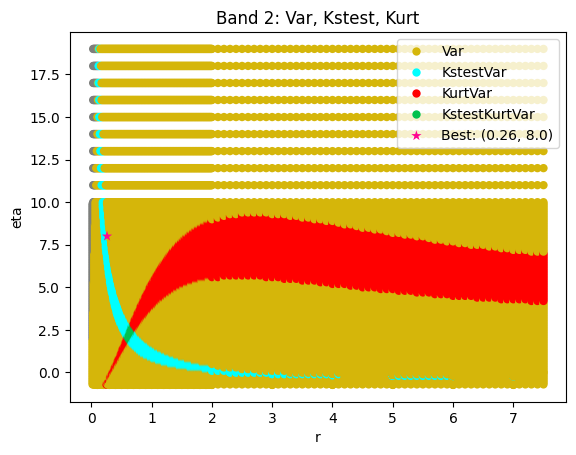

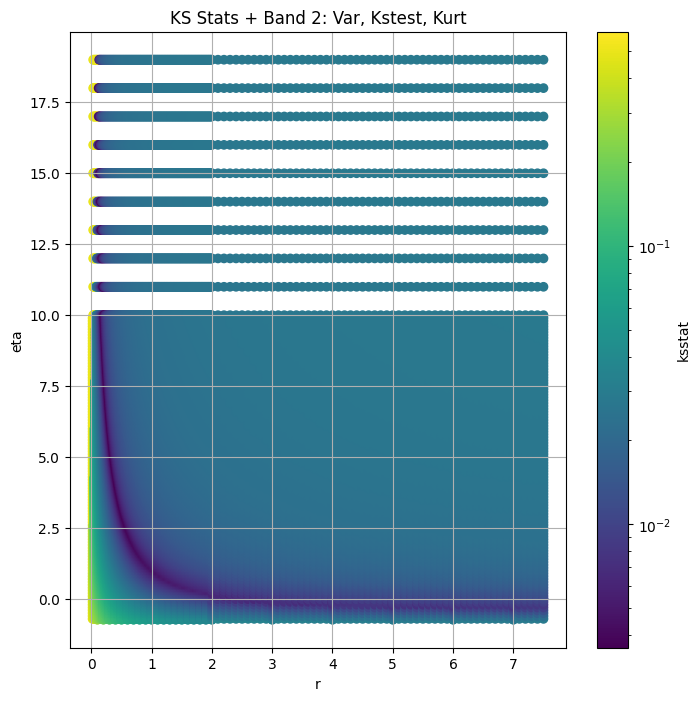

####
Band  5


100%|██████████| 55966/55966 [01:21<00:00, 687.70it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 41340, Without approximation : 41340.0


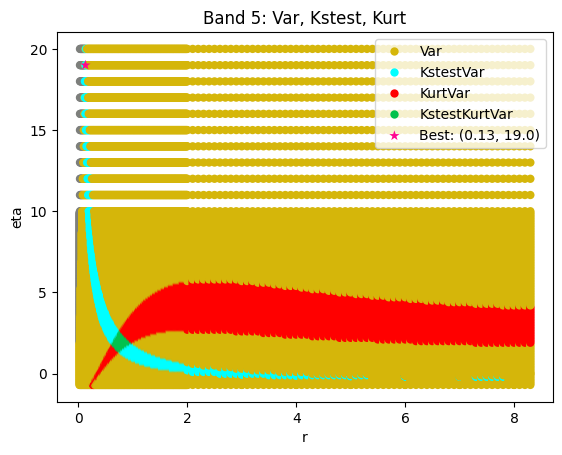

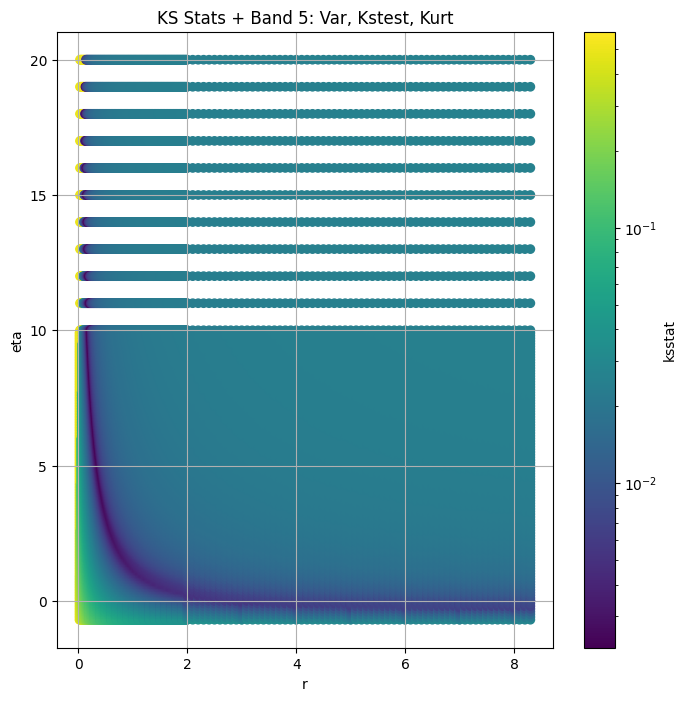

####
Band  8


100%|██████████| 55966/55966 [02:08<00:00, 435.34it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 66780, Without approximation : 66780.0


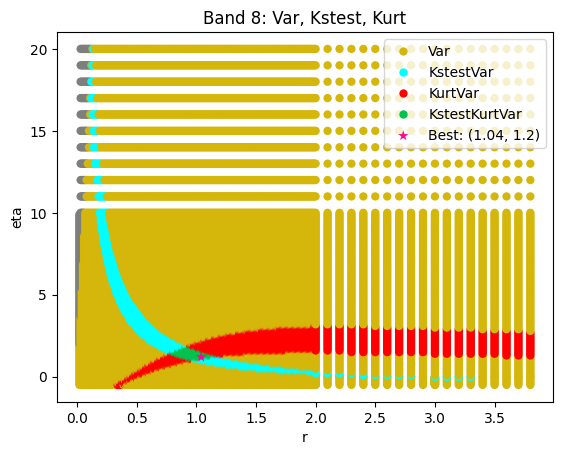

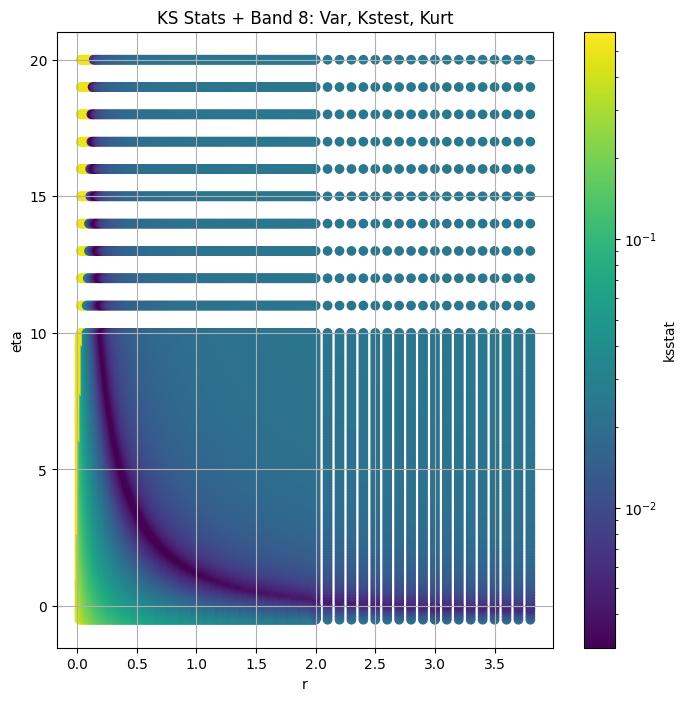

####
Band  11


100%|██████████| 55966/55966 [03:07<00:00, 297.92it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 104940.0


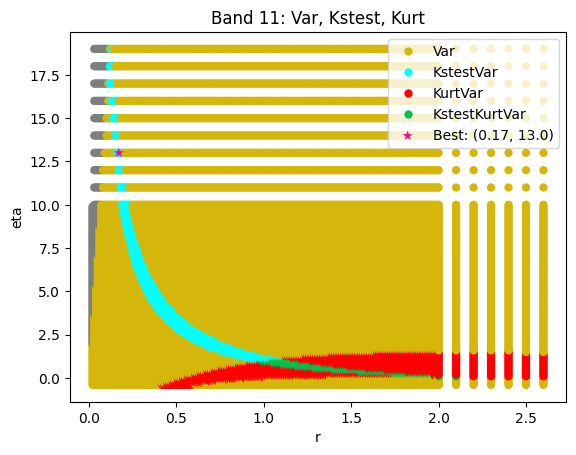

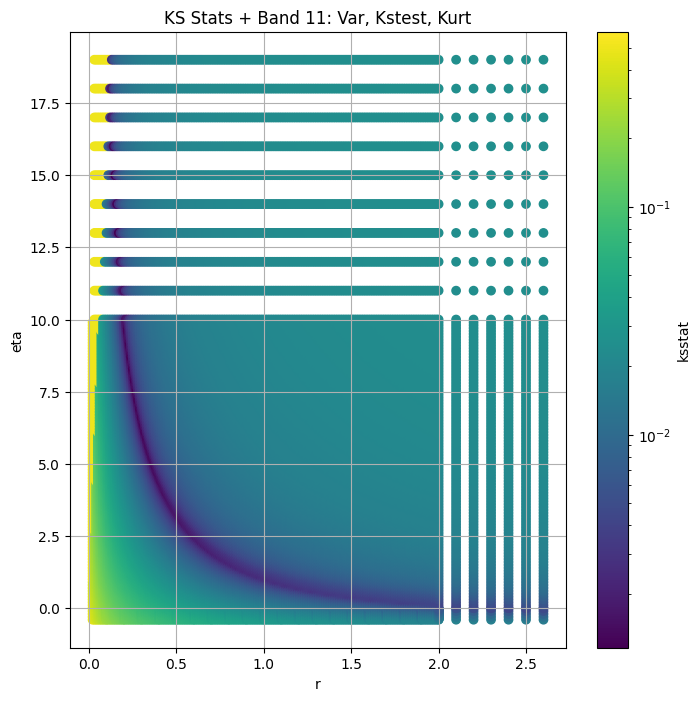

####
Band  14


100%|██████████| 55966/55966 [03:07<00:00, 298.76it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 162180.0


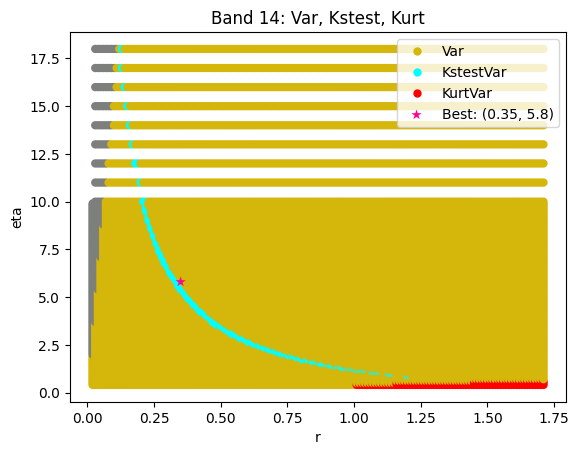

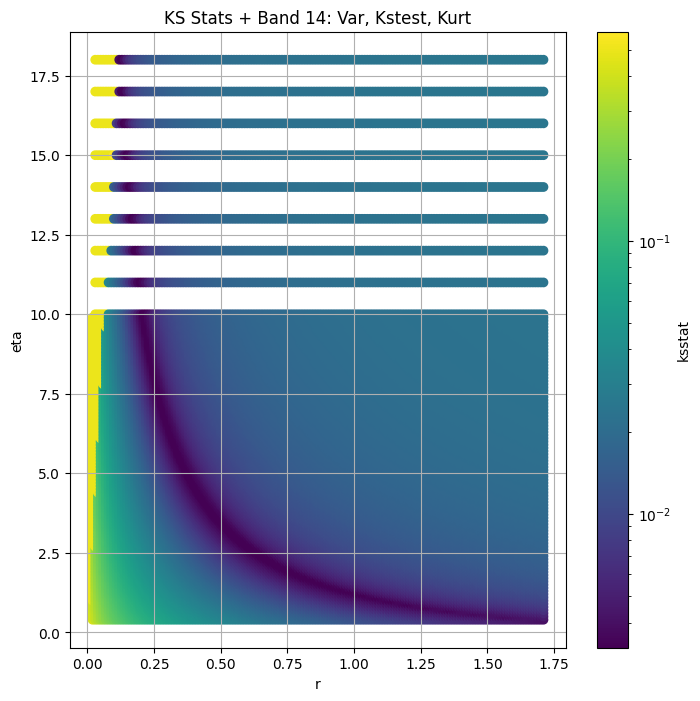

####
Band  17


100%|██████████| 55966/55966 [03:07<00:00, 298.73it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 257580.0


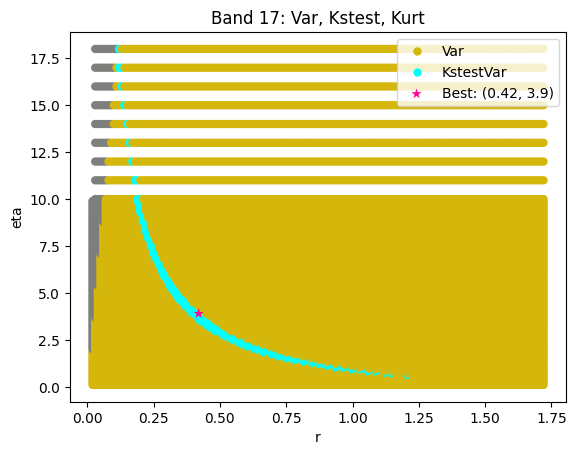

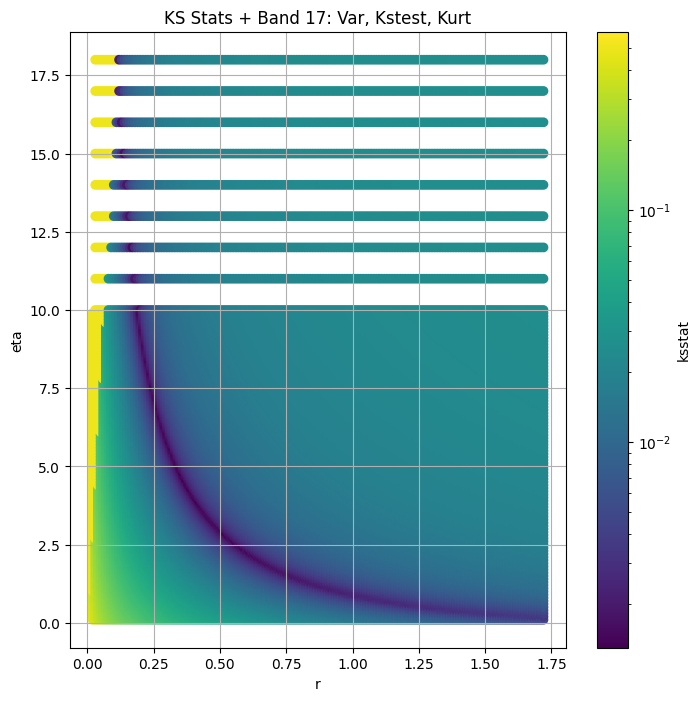

####
Band  20


100%|██████████| 55966/55966 [03:07<00:00, 298.18it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 381600.0


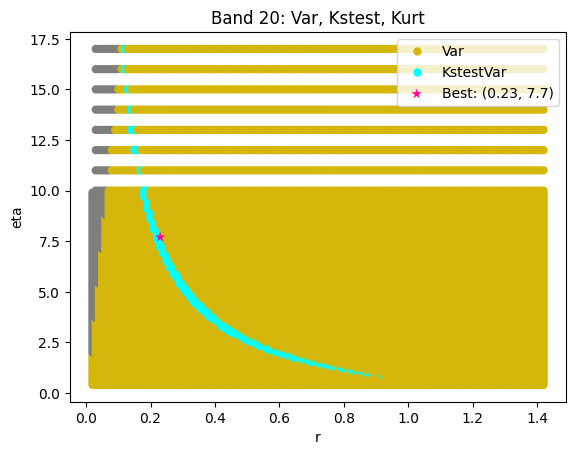

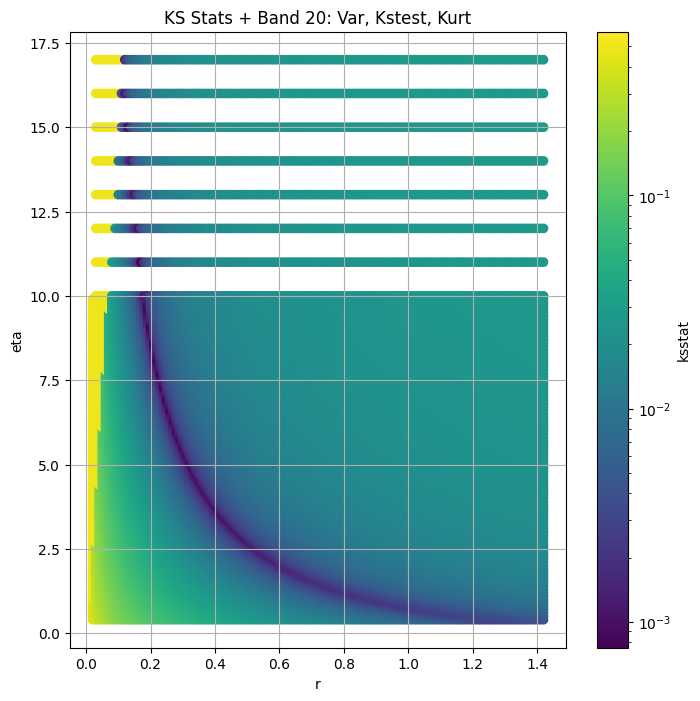

####
Band  23


100%|██████████| 55966/55966 [03:07<00:00, 297.76it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 610560.0


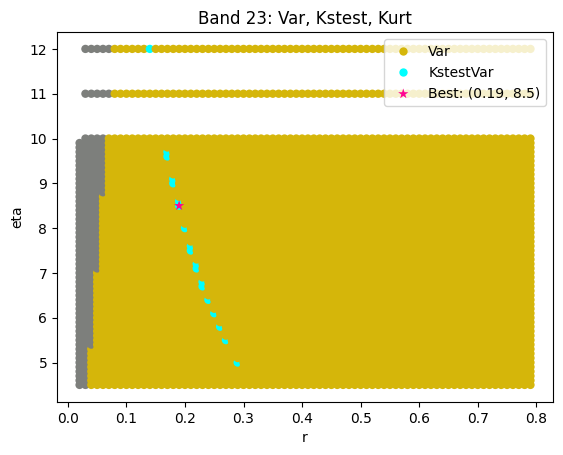

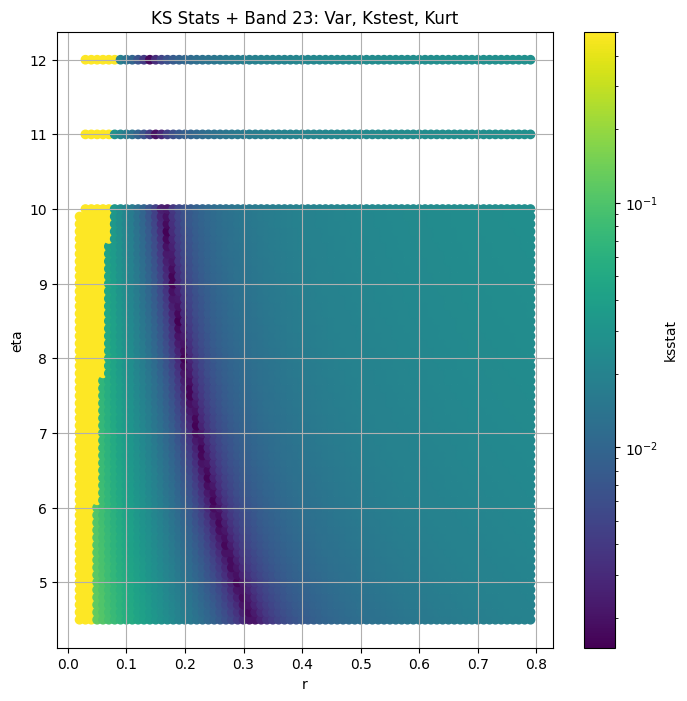

####
Band  26


100%|██████████| 55966/55966 [03:08<00:00, 296.20it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 973080.0


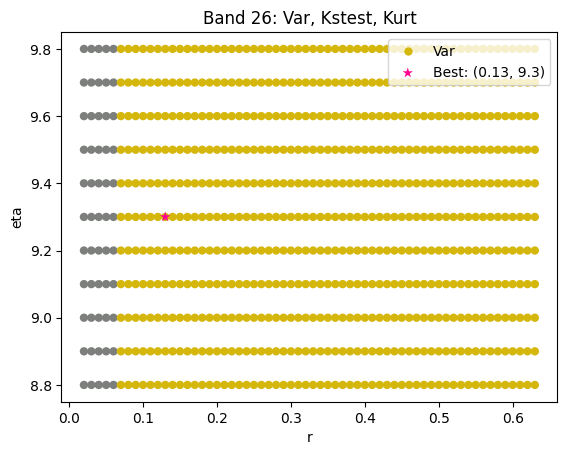

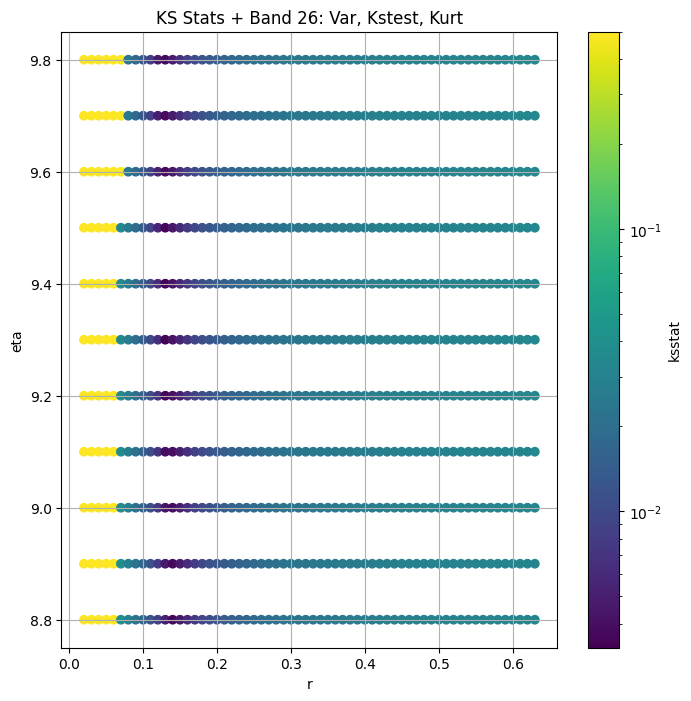

####
Band  29


100%|██████████| 55966/55966 [03:09<00:00, 296.11it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1376940.0


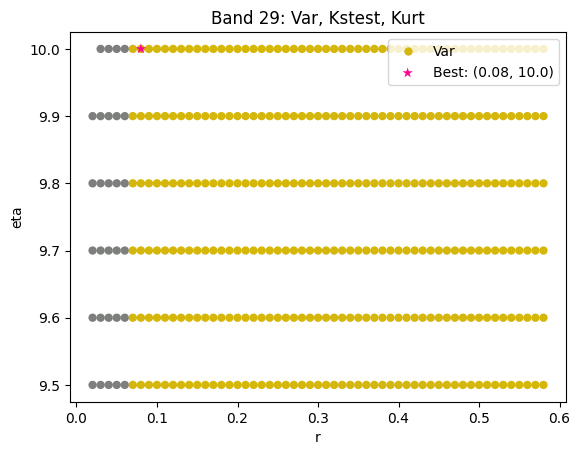

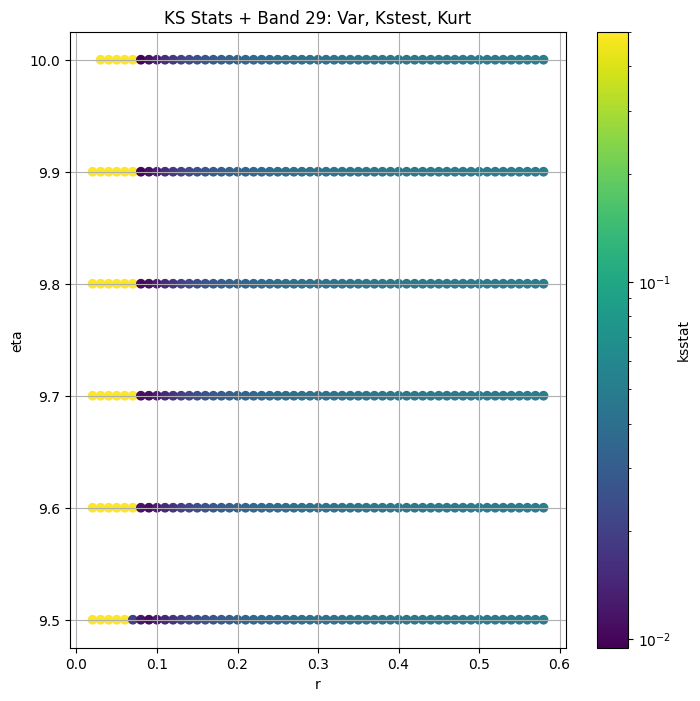

####
Band  32


100%|██████████| 55966/55966 [03:10<00:00, 294.53it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 419760.0


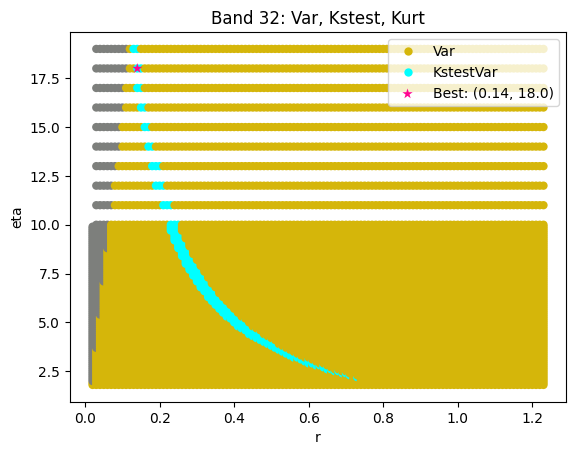

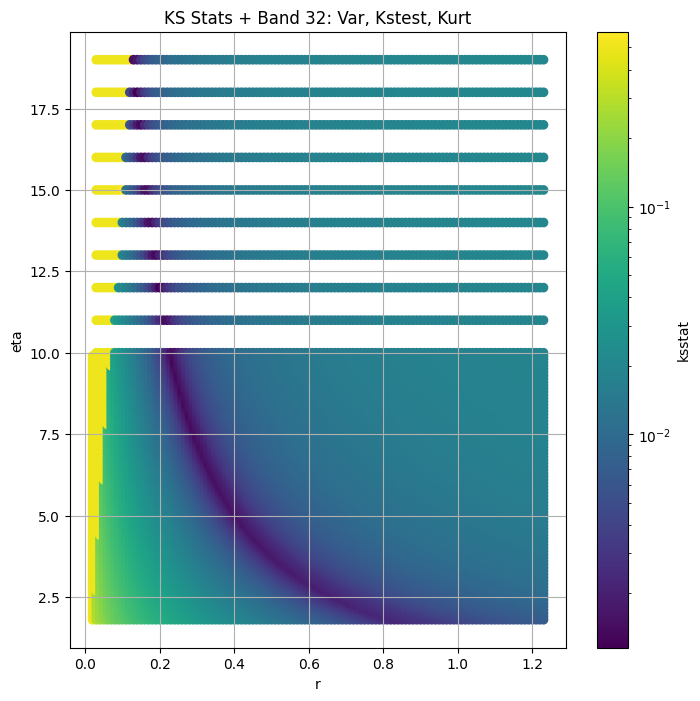

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     14.564291  13.887027  15.268839   1.329861    0.962390    1.772640   
5      7.681994   7.323771   8.055925   1.392025    0.909872    2.123118   
8      4.073018   3.884318   4.267340   1.377129    0.967720    1.917665   
11     2.242928   2.133372   2.357460   1.727334    1.042835    3.028584   
14     1.177406   1.121854   1.236006   1.563712    0.985900    3.021425   
17     0.631009   0.600541   0.662828   1.652823    1.062084    3.063314   
20     0.301410   0.286417   0.317915   2.060602    1.170981    6.707925   
23     0.134888   0.127928   0.142416   2.336577    1.422220    4.876342   
26     0.053216   0.049692   0.057507   5.787819    2.479208   17.814651   
29     0.018185   0.016213   0.021056  23.688461    6.687737   80.945920   
32     0.001581   0.001508   0.001656   1.305109    0.893868    2.017627   

      total_samples  initial_r  initial_eta  initial_scale  \
band                                                         
2           31800.0       0.26          8.0   1.229014e-05   
5           41340.0       0.13         19.0   8.117170e-17   
8           66780.0       1.04          1.2   1.638445e+00   
11         104940.0       0.17         13.0   8.333795e-12   
14         162180.0       0.35          5.8   1.771573e-04   
17         257580.0       0.42          3.9   1.277089e-03   
20         381600.0       0.23          7.7   2.735783e-08   
23         610560.0       0.19          8.5   9.569363e-11   
26         973080.0       0.13          9.3   6.760444e-17   
29        1376940.0       0.08         10.0   1.197460e-29   
32         419760.0       0.14         18.0   6.576789e-19   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.003604                 0.007611  
5                0.002263                 0.006675  
8                0.003009                 0.005253  
11               0.001161                 0.004191  
14               0.003234                 0.003371  
17               0.001297                 0.002675  
20               0.000755                 0.002198  
23               0.001512                 0.001738  
26               0.003288                 0.001377  
29               0.009453                 0.001157  
32               0.001153                 0.002096

In [9]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [10]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 818.79it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 652.87it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 424.06it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 278.38it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 289.52it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 287.83it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 289.73it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 281.97it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 287.07it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 288.85it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 289.68it/s]

Finding Minimum after computing 369 CDFs


obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     14.564291  13.887027  15.268839   1.329861    0.962390    1.772640   
5      7.681994   7.323771   8.055925   1.392025    0.909872    2.123118   
8      4.073018   3.884318   4.267340   1.377129    0.967720    1.917665   
11     2.242928   2.133372   2.357460   1.727334    1.042835    3.028584   
14     1.177406   1.121854   1.236006   1.563712    0.985900    3.021425   
17     0.631009   0.600541   0.662828   1.652823    1.062084    3.063314   
20     0.301410   0.286417   0.317915   2.060602    1.170981    6.707925   
23     0.134888   0.127928   0.142416   2.336577    1.422220    4.876342   
26     0.053216   0.049692   0.057507   5.787819    2.479208   17.814651   
29     0.018185   0.016213   0.021056  23.688461    6.687737   80.945920   
32     0.001581   0.001508   0.001656   1.305109    0.893868    2.017627   

      total_samples  initial_r  initial_eta  initial_scale  \
band                                                         
2           31800.0       0.26          8.0   1.229014e-05   
5           41340.0       0.13         19.0   8.117170e-17   
8           66780.0       1.04          1.2   1.638445e+00   
11         104940.0       0.17         13.0   8.333795e-12   
14         162180.0       0.35          5.8   1.771573e-04   
17         257580.0       0.42          3.9   1.277089e-03   
20         381600.0       0.23          7.7   2.735783e-08   
23         610560.0       0.19          8.5   9.569363e-11   
26         973080.0       0.13          9.3   6.760444e-17   
29        1376940.0       0.08         10.0   1.197460e-29   
32         419760.0       0.14         18.0   6.576789e-19   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.003604                 0.007611          5.8   
5                0.002263                 0.006675          5.8   
8                0.003009                 0.005253          5.8   
11               0.001161                 0.004191          5.8   
14               0.003234                 0.003371          5.8   
17               0.001297                 0.002675          5.8   
20               0.000755                 0.002198          5.8   
23               0.001512                 0.001738          5.8   
26               0.003288                 0.001377          5.8   
29               0.009453                 0.001157          5.8   
32               0.001153                 0.002096          5.8   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2            0.002691          0.473541  
5            0.002691          0.480006  
8            0.002691          0.484583  
11           0.002691          0.488136  
14           0.002691          0.490938  
17           0.002691          0.493012  
20           0.002691          0.494846  
23           0.002691          0.496242  
26           0.002691          0.497106  
29           0.002691          0.497649  
32           0.002691          0.499545

## Optimization

In [11]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.252, 7.99), 50 of 420
(0.254, 8.09), 100 of 420
(0.257, 7.99), 150 of 420
(0.259, 8.09), 200 of 420
(0.262, 7.99), 250 of 420
(0.264, 8.09), 300 of 420
(0.267, 7.99), 350 of 420
(0.269, 8.09), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 909.28it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 2 best parameters: ((0.261, 7.96), 0.003600951181242207)


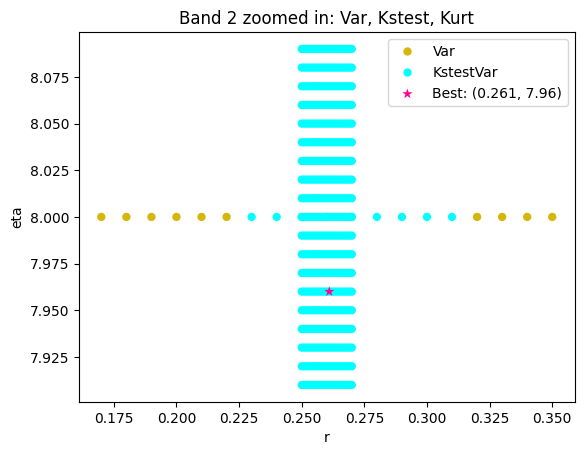

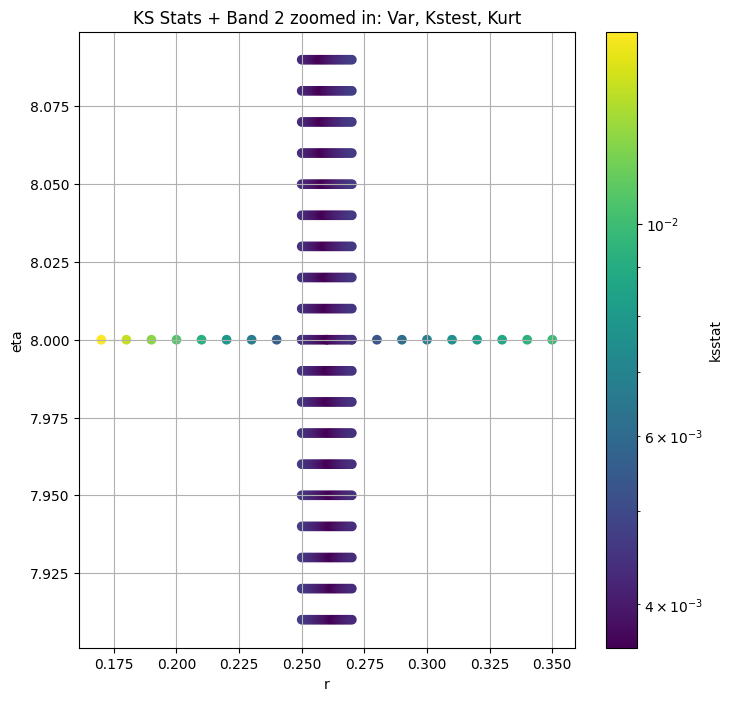

Band 5


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


(0.122, 18.9), 50 of 420
(0.124, 19.9), 100 of 420
(0.127, 18.9), 150 of 420
(0.129, 19.9), 200 of 420
(0.132, 18.9), 250 of 420
(0.134, 19.9), 300 of 420
(0.137, 18.9), 350 of 420
(0.139, 19.9), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((0.128, 19.4), 0.002212089576256848)


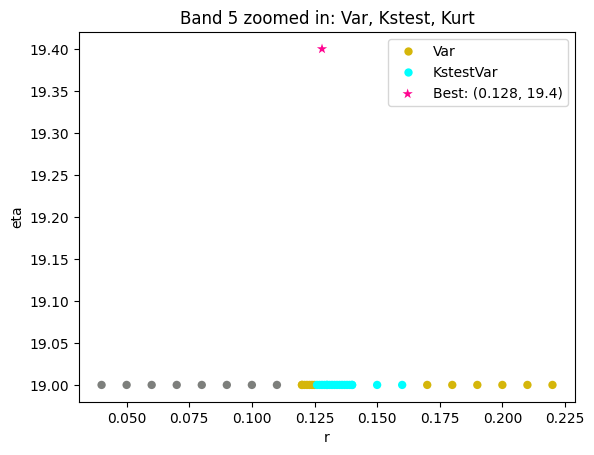

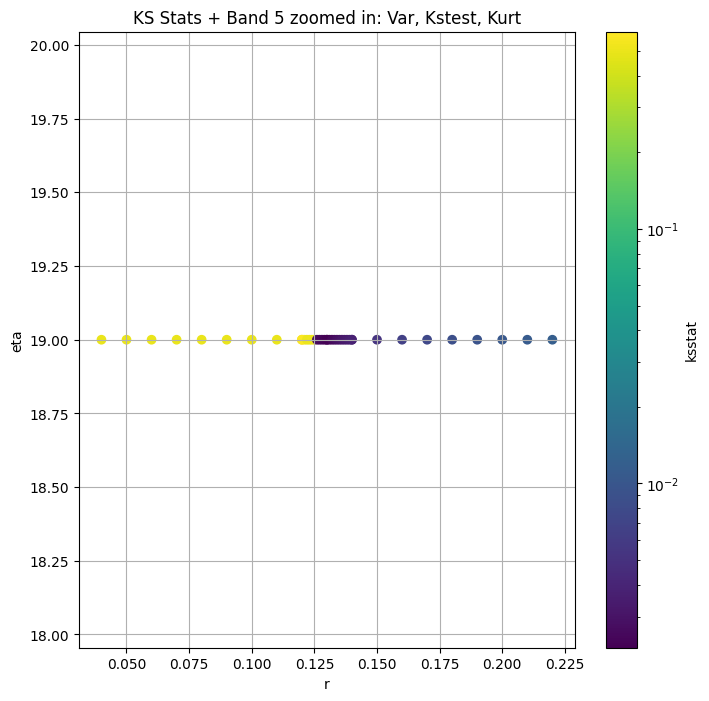

Band 8
(1.032, 1.17), 50 of 441
(1.034, 1.25), 100 of 441
(1.037, 1.12), 150 of 441
(1.039, 1.2), 200 of 441
(1.041, 1.28), 250 of 441
(1.044, 1.15), 300 of 441
(1.046, 1.23), 350 of 441
(1.049, 1.1), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 444.61it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 8 best parameters: ((1.049, 1.18), 0.003006337792053615)


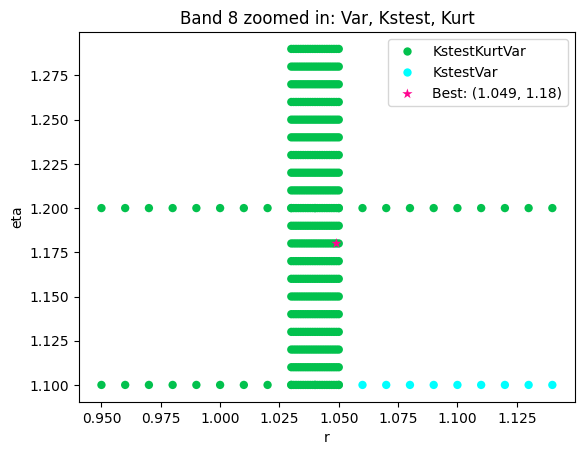

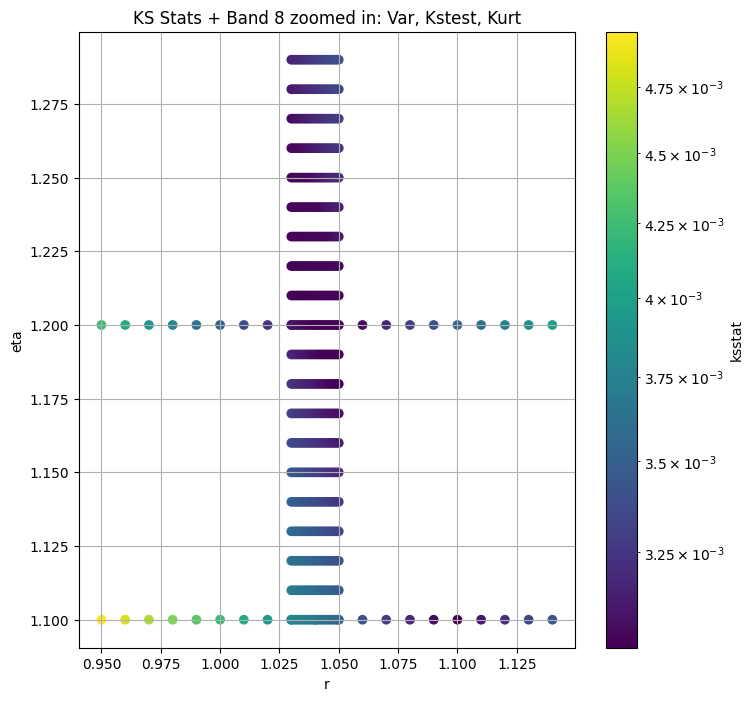

Band 11
(0.162, 12.9), 50 of 420
(0.164, 13.9), 100 of 420
(0.167, 12.9), 150 of 420
(0.169, 13.9), 200 of 420
(0.172, 12.9), 250 of 420
(0.174, 13.9), 300 of 420
(0.177, 12.9), 350 of 420
(0.179, 13.9), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:01<00:00, 299.19it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 11 best parameters: ((0.176, 12.5), 0.0011571255488004306)


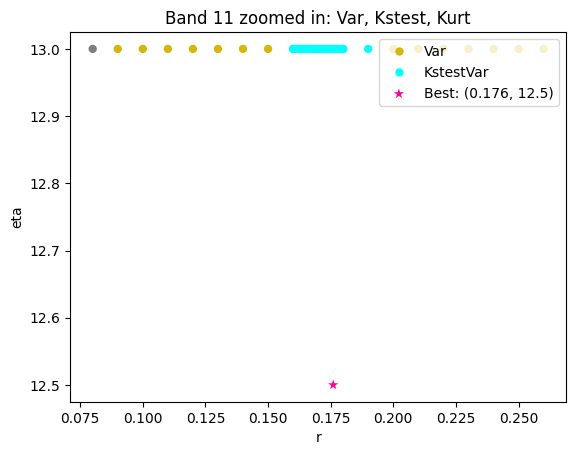

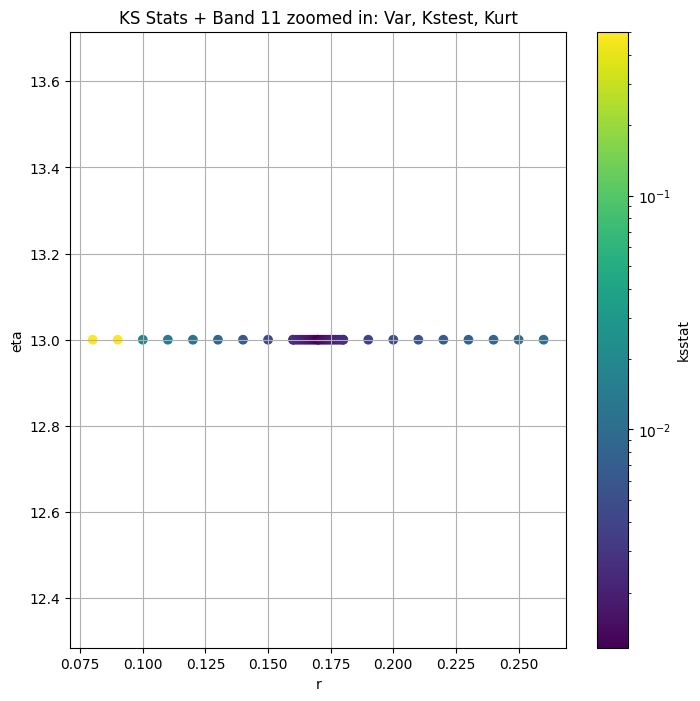

Band 14
(0.342, 5.79), 50 of 420
(0.344, 5.89), 100 of 420
(0.347, 5.79), 150 of 420
(0.349, 5.89), 200 of 420
(0.352, 5.79), 250 of 420
(0.354, 5.89), 300 of 420
(0.357, 5.79), 350 of 420
(0.359, 5.89), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 299.99it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.351, 5.78), 0.0032339559095213577)


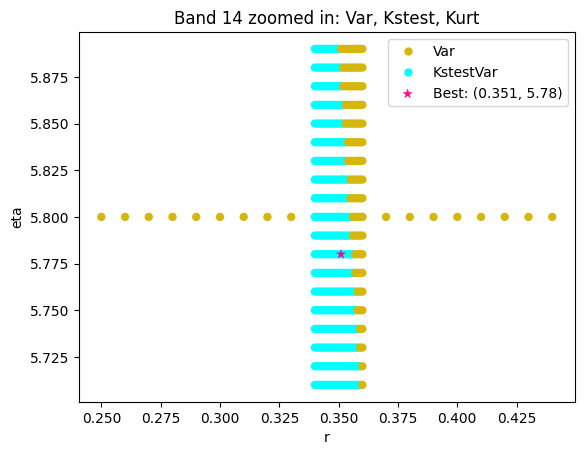

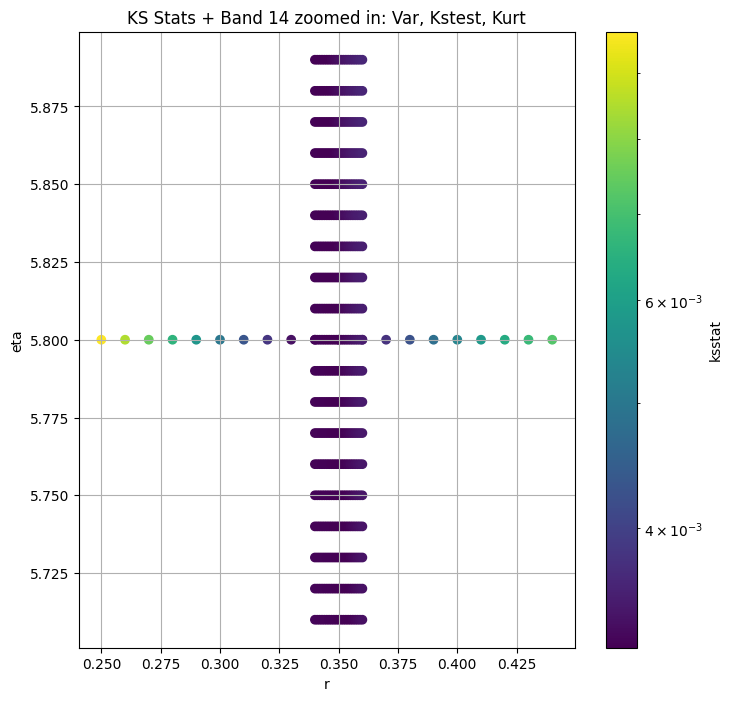

Band 17
(0.412, 3.87), 50 of 441
(0.414, 3.95), 100 of 441
(0.417, 3.82), 150 of 441
(0.419, 3.9), 200 of 441
(0.421, 3.98), 250 of 441
(0.424, 3.85), 300 of 441
(0.426, 3.93), 350 of 441
(0.429, 3.8), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 298.23it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 17 best parameters: ((0.417, 3.94), 0.001289815034759112)


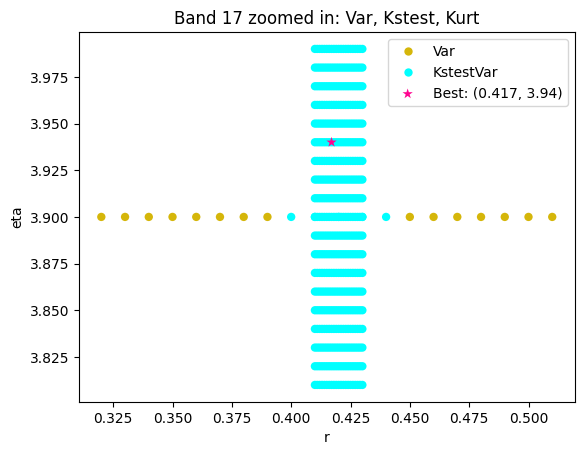

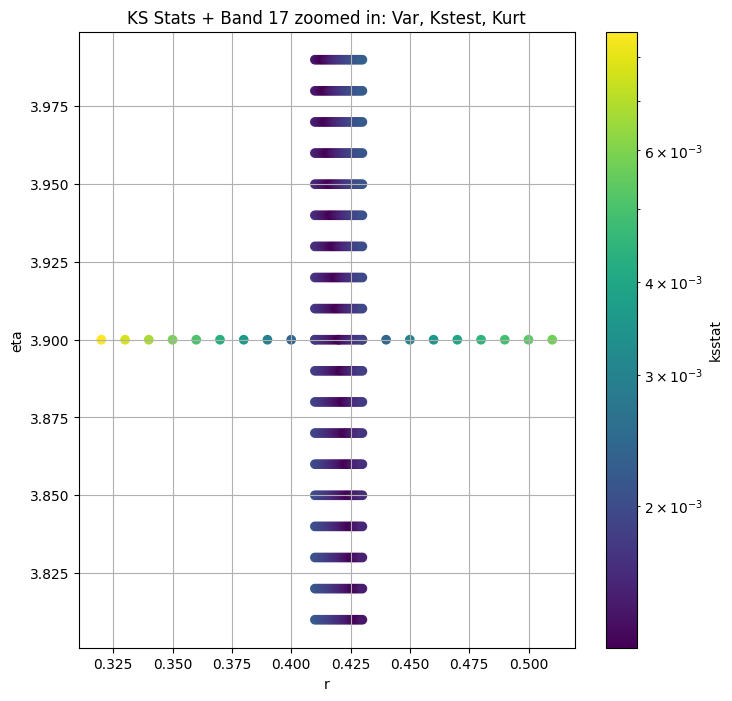

Band 20
(0.222, 7.69), 50 of 420
(0.224, 7.79), 100 of 420
(0.227, 7.69), 150 of 420
(0.229, 7.79), 200 of 420
(0.232, 7.69), 250 of 420
(0.234, 7.79), 300 of 420
(0.237, 7.69), 350 of 420
(0.239, 7.79), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 298.72it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.228, 7.78), 0.0007495012552701796)


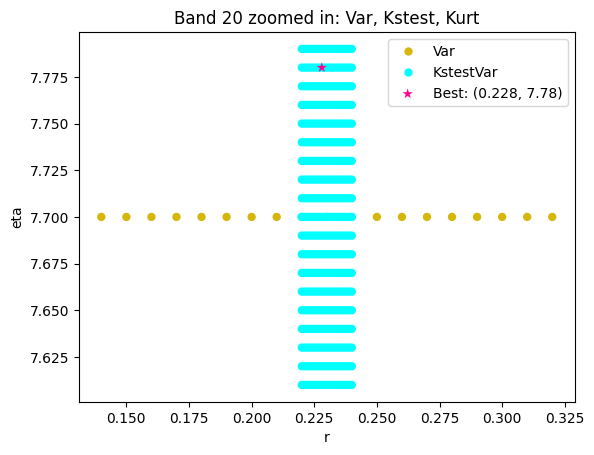

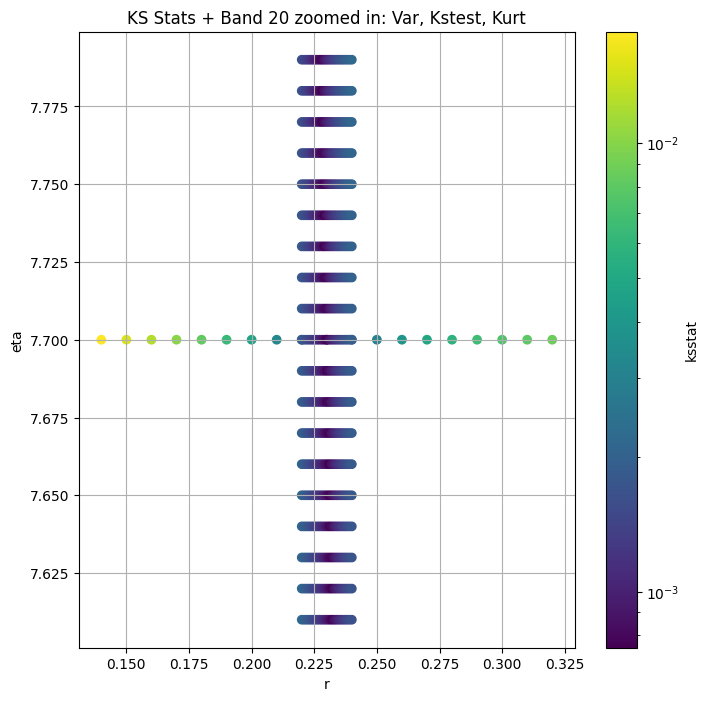

Band 23
(0.182, 8.49), 50 of 420
(0.184, 8.59), 100 of 420
(0.187, 8.49), 150 of 420
(0.189, 8.59), 200 of 420
(0.192, 8.49), 250 of 420
(0.194, 8.59), 300 of 420
(0.197, 8.49), 350 of 420
(0.199, 8.59), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 300.56it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.191, 8.44), 0.0015042436864588504)


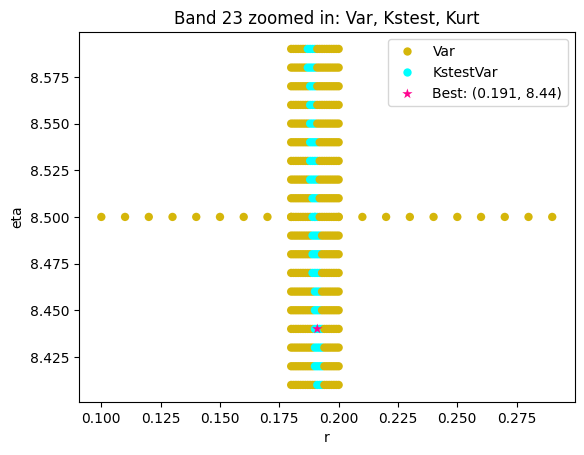

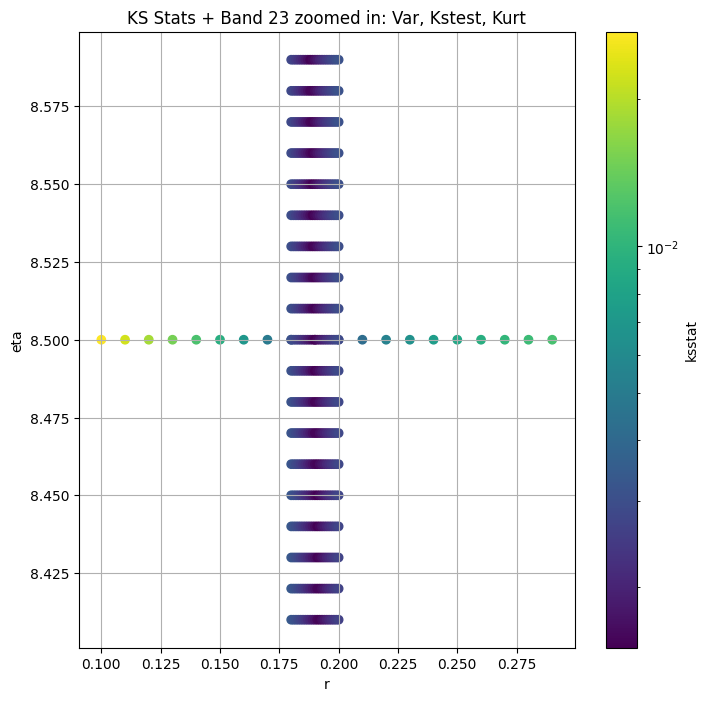

Band 26
(0.122, 9.29), 50 of 420
(0.124, 9.39), 100 of 420
(0.127, 9.29), 150 of 420
(0.129, 9.39), 200 of 420
(0.132, 9.29), 250 of 420
(0.134, 9.39), 300 of 420
(0.137, 9.29), 350 of 420
(0.139, 9.39), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:01<00:00, 299.51it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 26 best parameters: ((0.129, 9.36), 0.0032584561441959536)


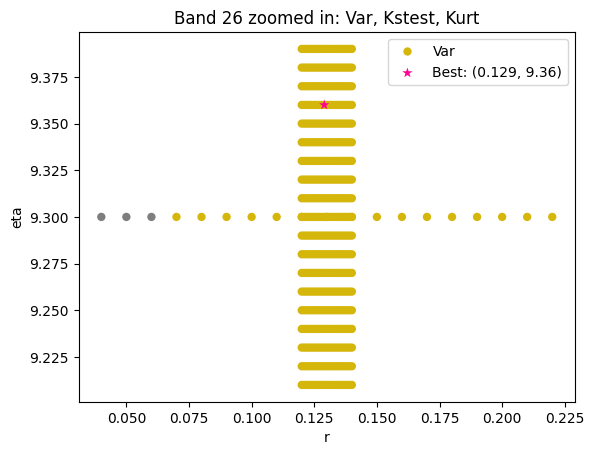

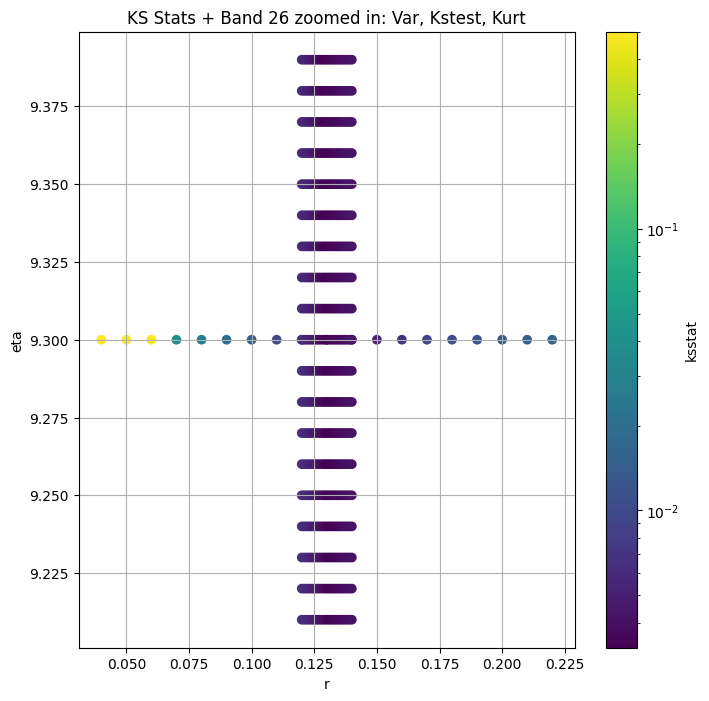

Band 29


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


(0.072, 9.9), 50 of 400
(0.074, 10.9), 100 of 400
(0.077, 9.9), 150 of 400
(0.079, 10.9), 200 of 400
(0.082, 9.9), 250 of 400
(0.084, 10.9), 300 of 400
(0.087, 9.9), 350 of 400
(0.089, 10.9), 400 of 400


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

Finding Minimum after computing 400 CDFs
Iter 1 band 29 best parameters: ((0.079, 10.1), 0.00942486608446258)


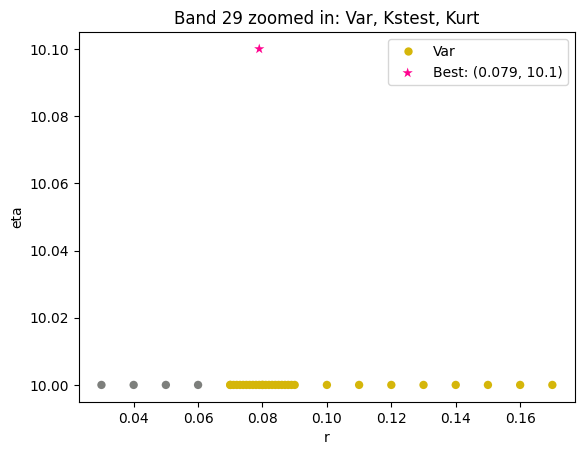

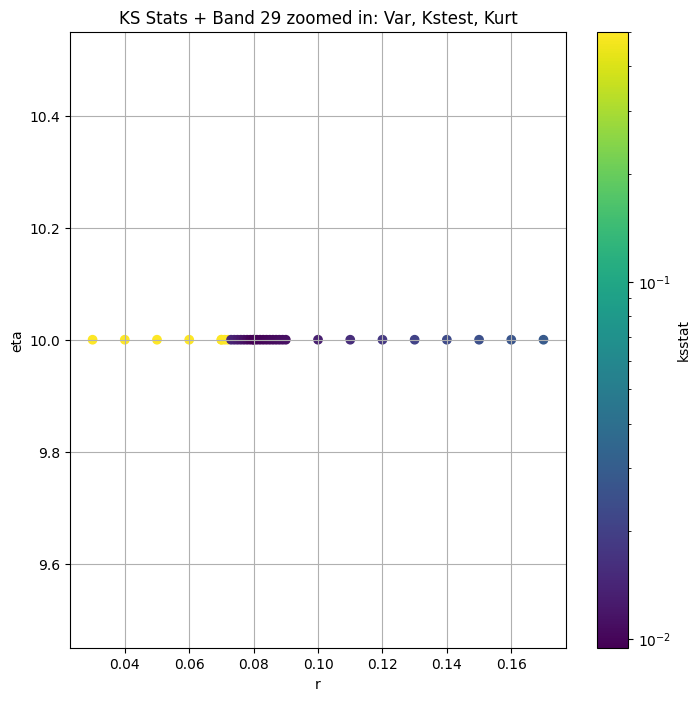

Band 32
(0.132, 17.9), 50 of 420
(0.134, 18.9), 100 of 420
(0.137, 17.9), 150 of 420
(0.139, 18.9), 200 of 420
(0.142, 17.9), 250 of 420
(0.144, 18.9), 300 of 420
(0.147, 17.9), 350 of 420
(0.149, 18.9), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:01<00:00, 298.64it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 32 best parameters: ((0.134, 18.8), 0.0011039520498423716)


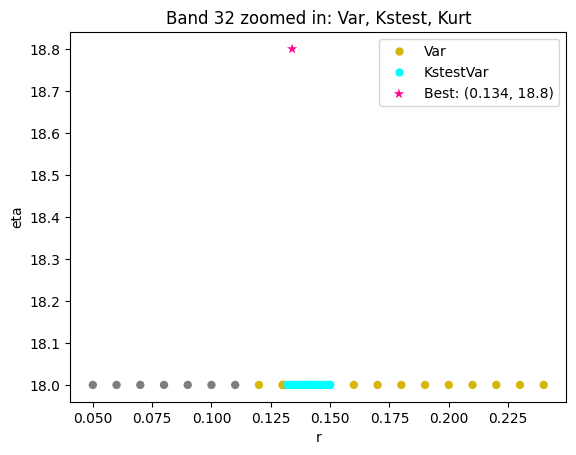

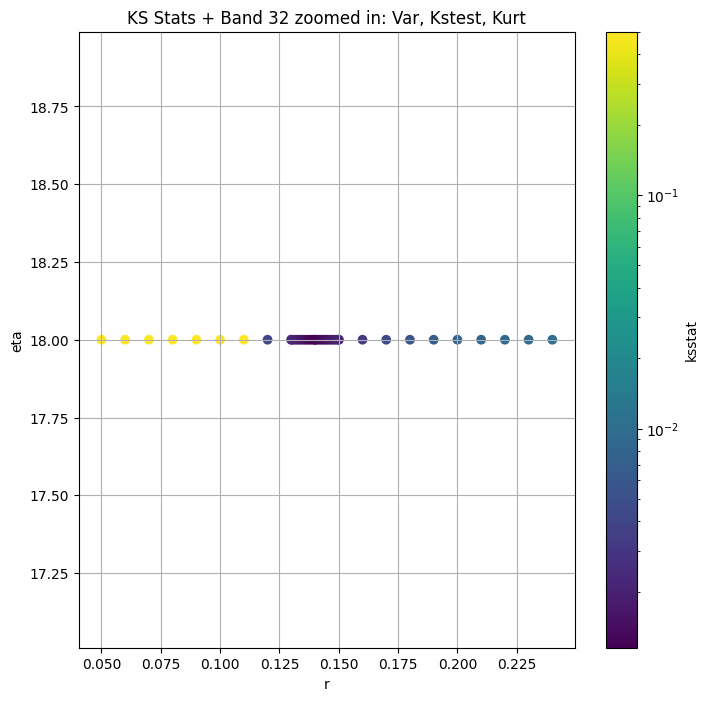

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     14.564291  13.887027  15.268839   1.329861    0.962390    1.772640   
5      7.681994   7.323771   8.055925   1.392025    0.909872    2.123118   
8      4.073018   3.884318   4.267340   1.377129    0.967720    1.917665   
11     2.242928   2.133372   2.357460   1.727334    1.042835    3.028584   
14     1.177406   1.121854   1.236006   1.563712    0.985900    3.021425   
17     0.631009   0.600541   0.662828   1.652823    1.062084    3.063314   
20     0.301410   0.286417   0.317915   2.060602    1.170981    6.707925   
23     0.134888   0.127928   0.142416   2.336577    1.422220    4.876342   
26     0.053216   0.049692   0.057507   5.787819    2.479208   17.814651   
29     0.018185   0.016213   0.021056  23.688461    6.687737   80.945920   
32     0.001581   0.001508   0.001656   1.305109    0.893868    2.017627   

      total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                        ...   
2           31800.0       0.26          8.0   1.229014e-05  ...   
5           41340.0       0.13         19.0   8.117170e-17  ...   
8           66780.0       1.04          1.2   1.638445e+00  ...   
11         104940.0       0.17         13.0   8.333795e-12  ...   
14         162180.0       0.35          5.8   1.771573e-04  ...   
17         257580.0       0.42          3.9   1.277089e-03  ...   
20         381600.0       0.23          7.7   2.735783e-08  ...   
23         610560.0       0.19          8.5   9.569363e-11  ...   
26         973080.0       0.13          9.3   6.760444e-17  ...   
29        1376940.0       0.08         10.0   1.197460e-29  ...   
32         419760.0       0.14         18.0   6.576789e-19  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2            0.002691          0.473541   0.261      7.96  1.336787e-05   
5            0.002691          0.480006   0.128     19.40  3.366372e-17   
8            0.002691          0.484583   1.049      1.18  1.679367e+00   
11           0.002691          0.488136   0.176     12.50  3.025344e-11   
14           0.002691          0.490938   0.351      5.78  1.845501e-04   
17           0.002691          0.493012   0.417      3.94  1.179762e-03   
20           0.002691          0.494846   0.228      7.78  2.201055e-08   
23           0.002691          0.496242   0.191      8.44  1.132372e-10   
26           0.002691          0.497106   0.129      9.36  4.681799e-17   
29           0.002691          0.497649   0.079     10.10  4.159236e-30   
32           0.002691          0.499545   0.134     18.80  7.232753e-20   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.003601    0.261       7.96           0.003601       135831  
5             0.002212    0.128      19.40           0.002212       397309  
8             0.003006    1.049       1.18           0.003006       213934  
11            0.001157    0.176      12.50           0.001157      1344745  
14            0.003234    0.351       5.78           0.003234       182452  
17            0.001290    0.417       3.94           0.001290      1100247  
20            0.000750    0.228       7.78           0.000750      3259996  
23            0.001504    0.191       8.44           0.001504       825184  
26            0.003258    0.129       9.36           0.003258       182452  
29            0.009425    0.079      10.10           0.009425        21514  
32            0.001104    0.134      18.80           0.001104      1593775  

[11 rows x 23 columns]

In [12]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

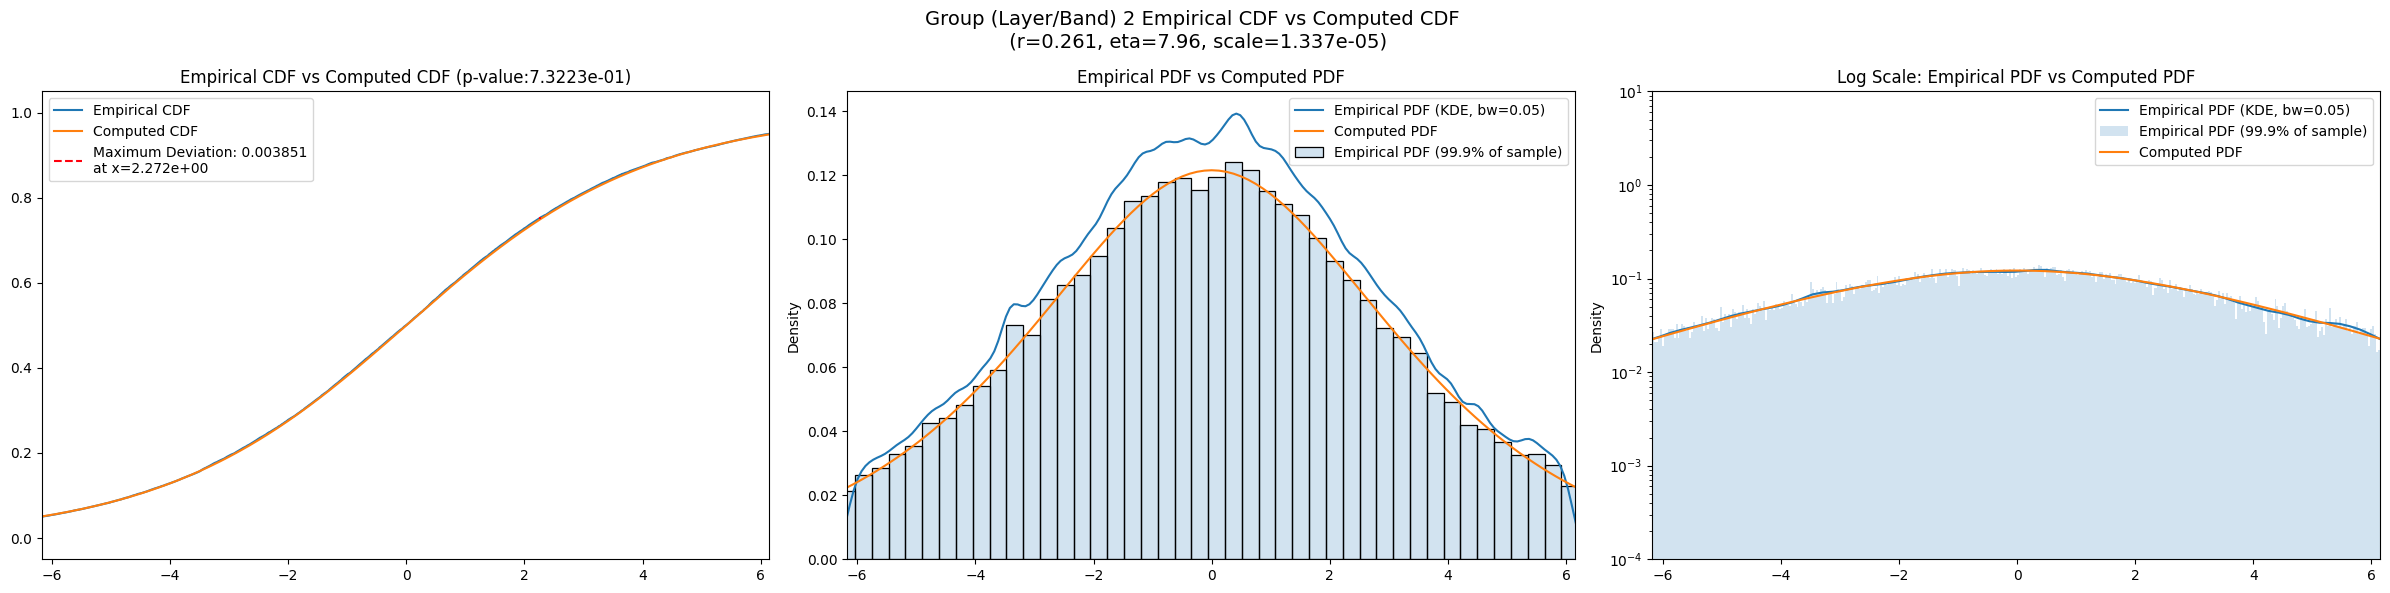

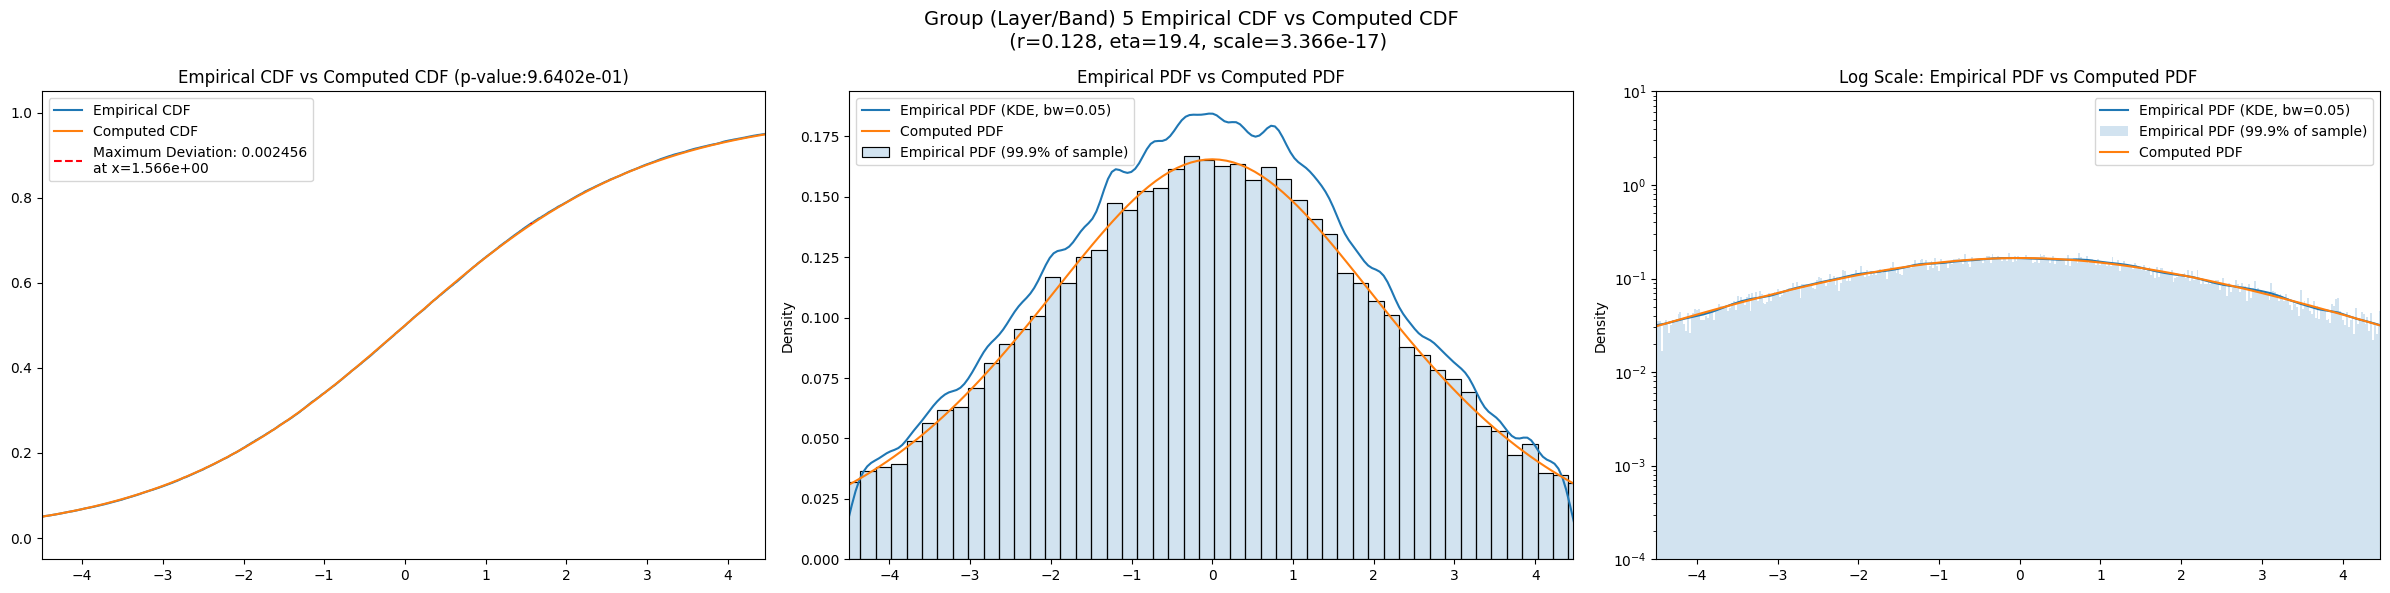

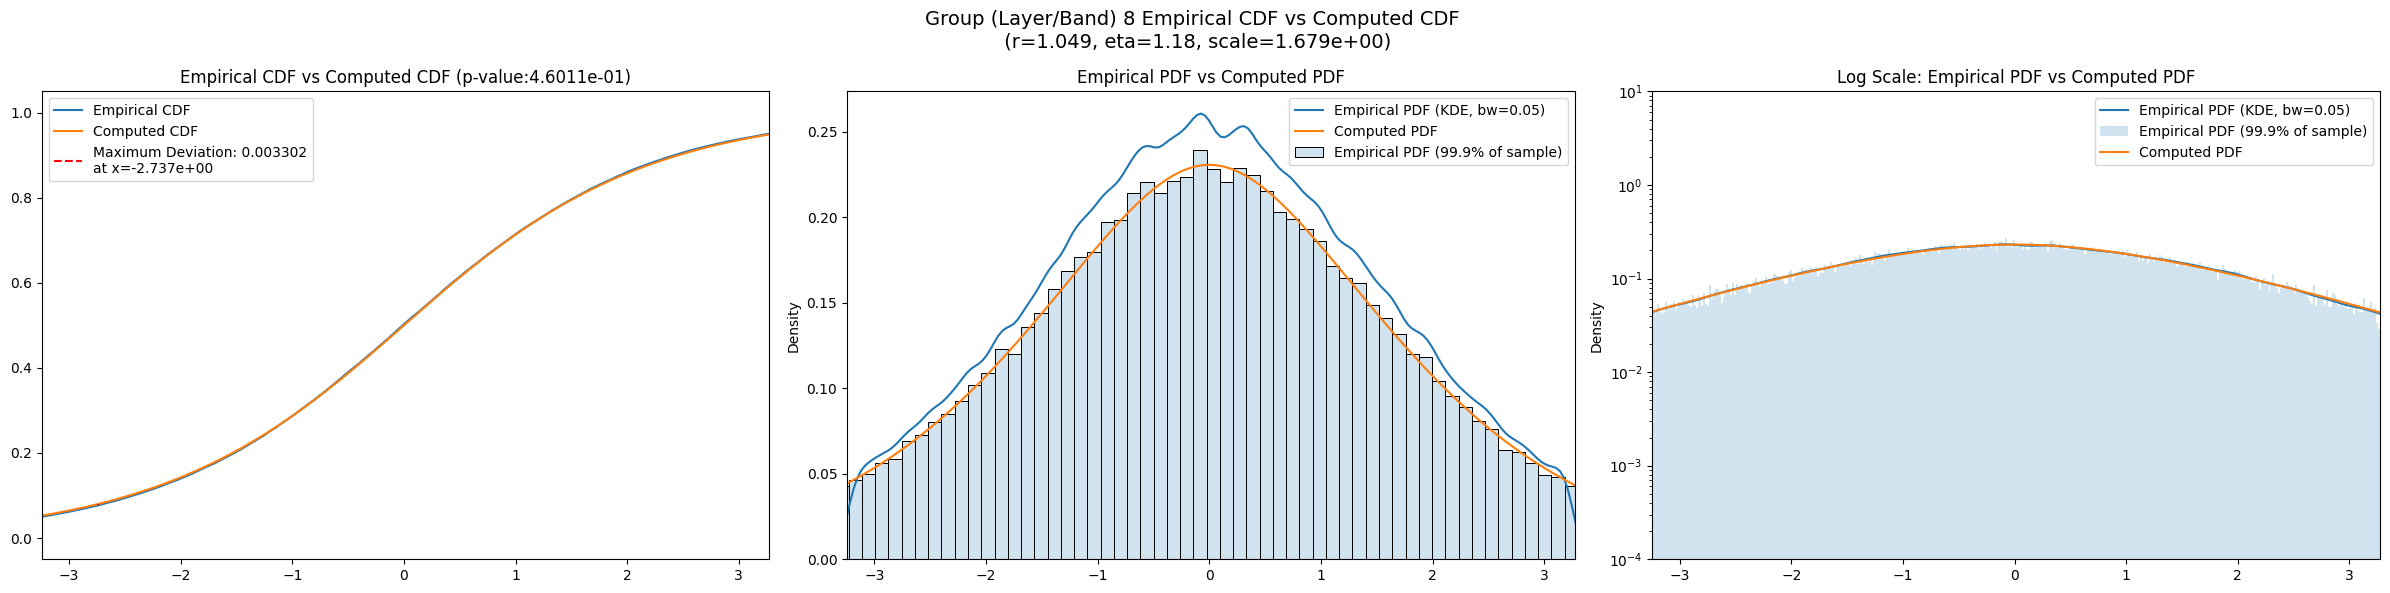

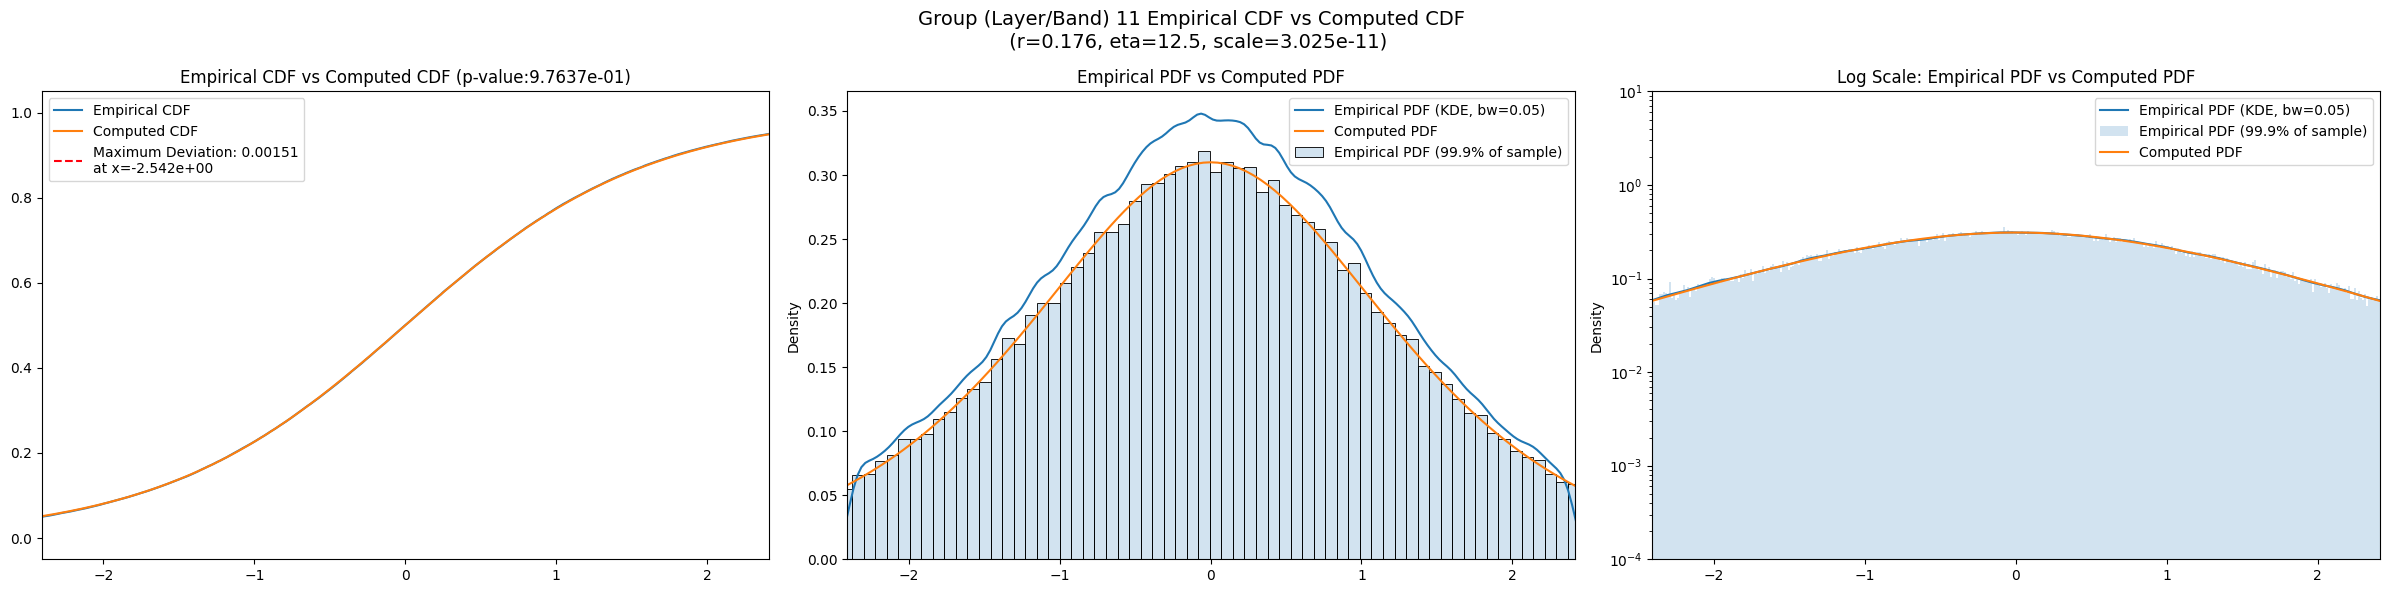

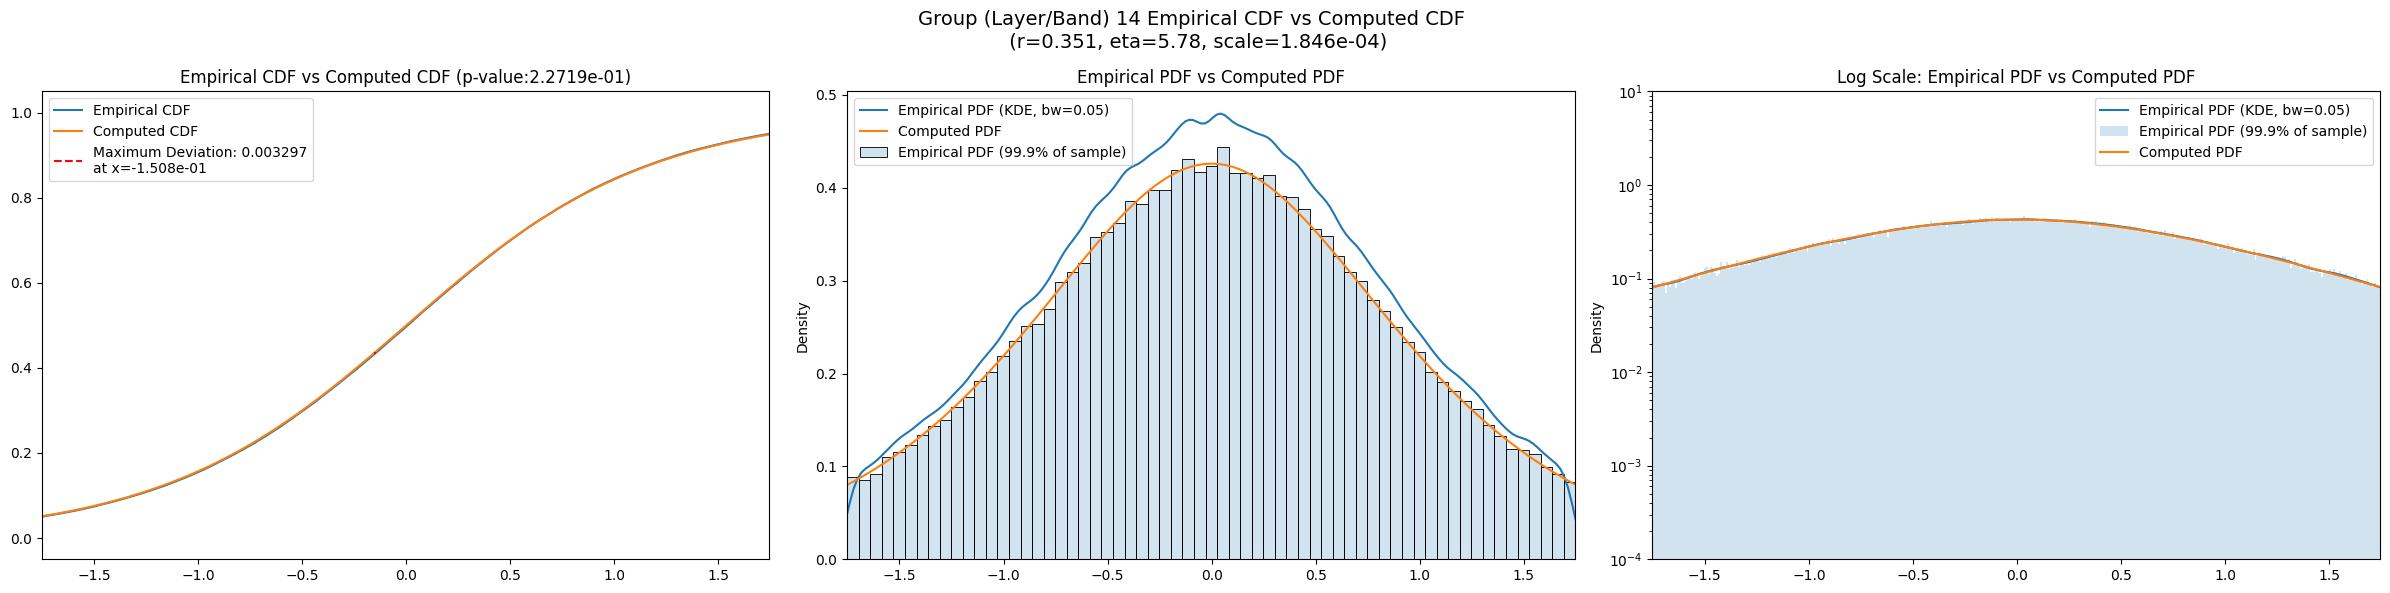

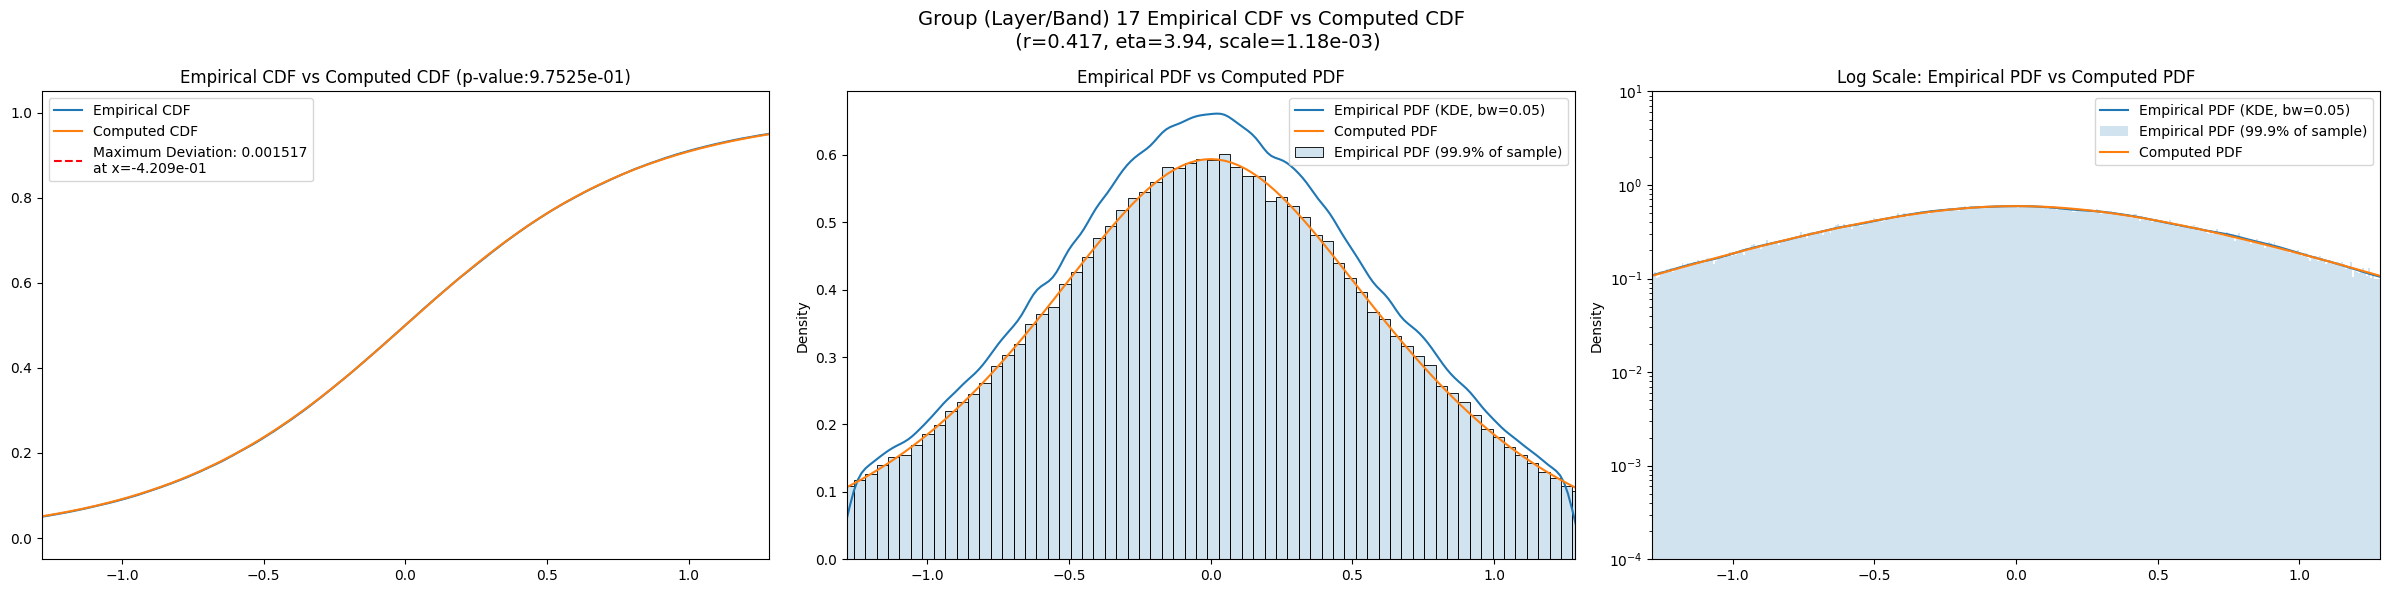

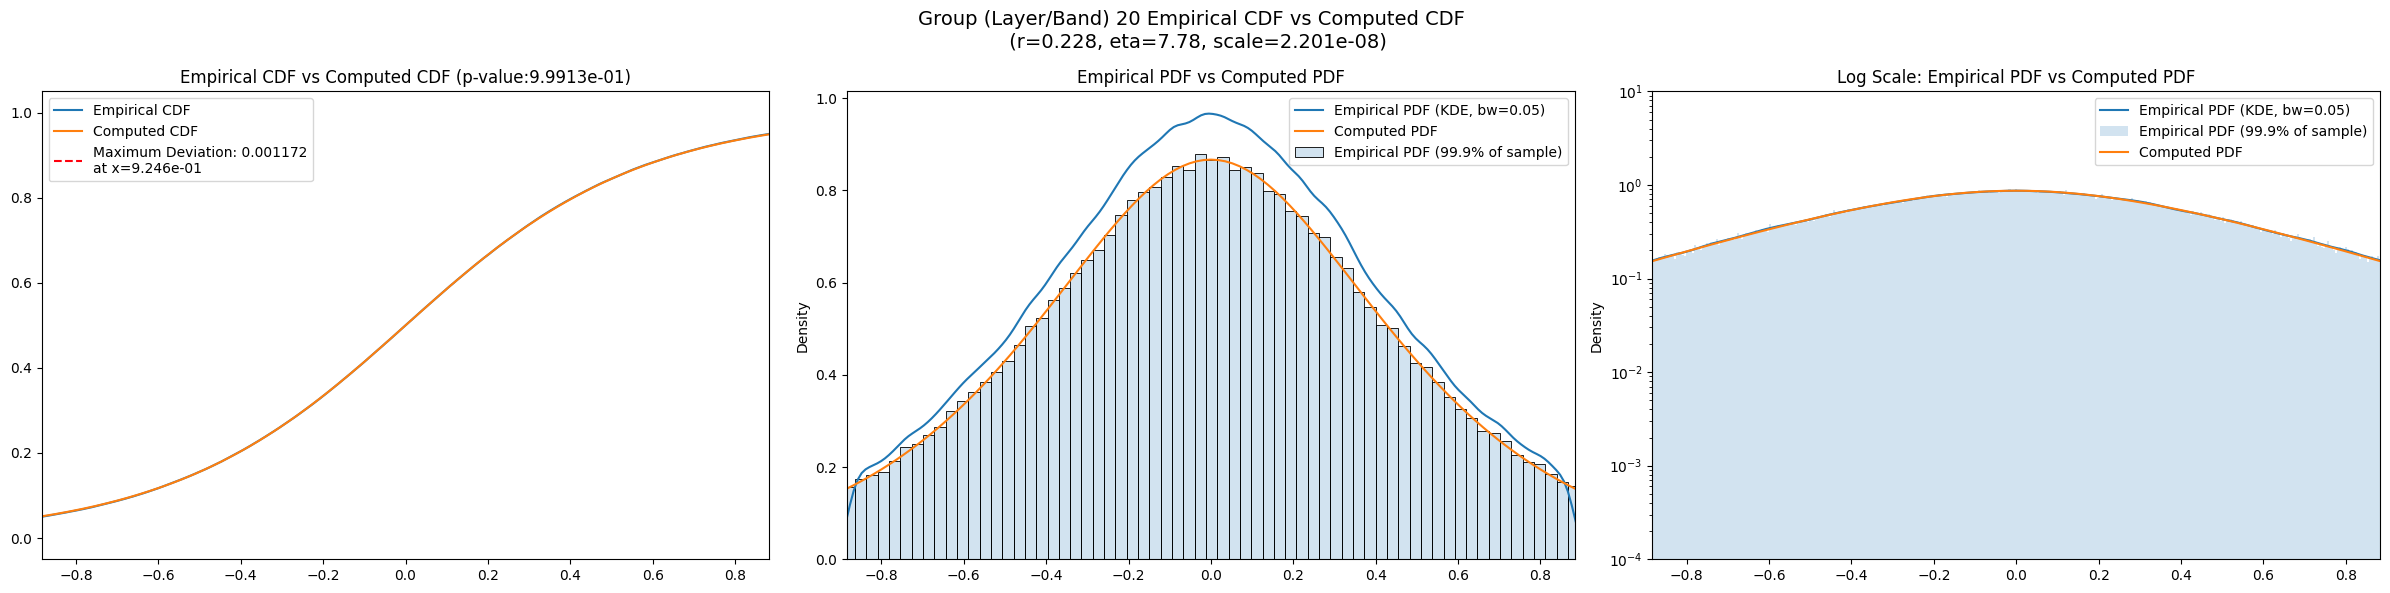

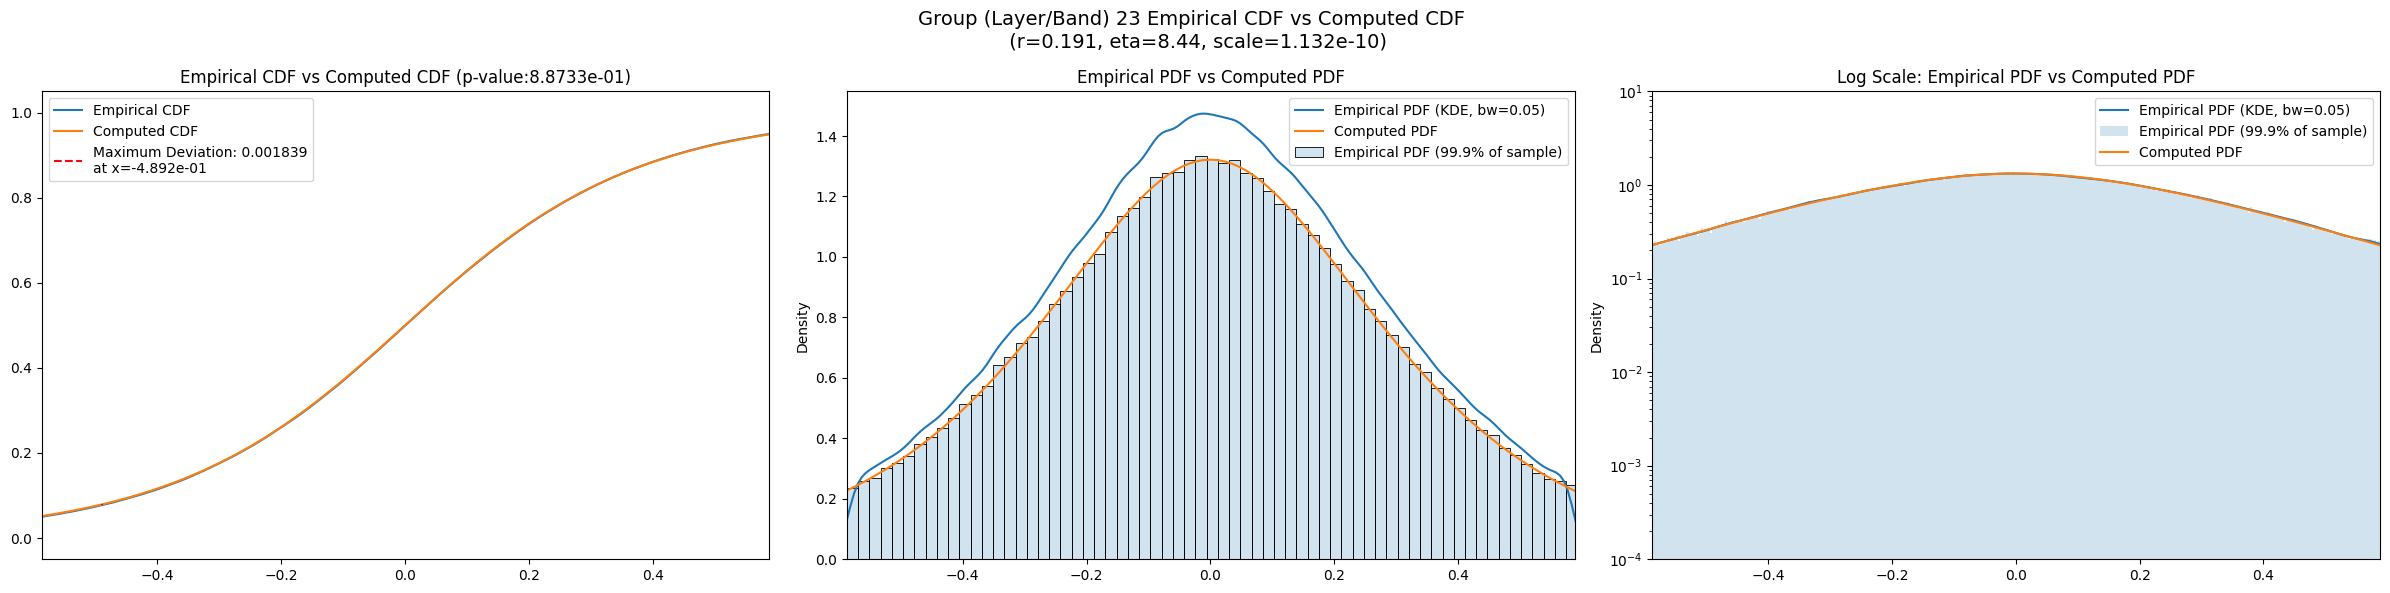

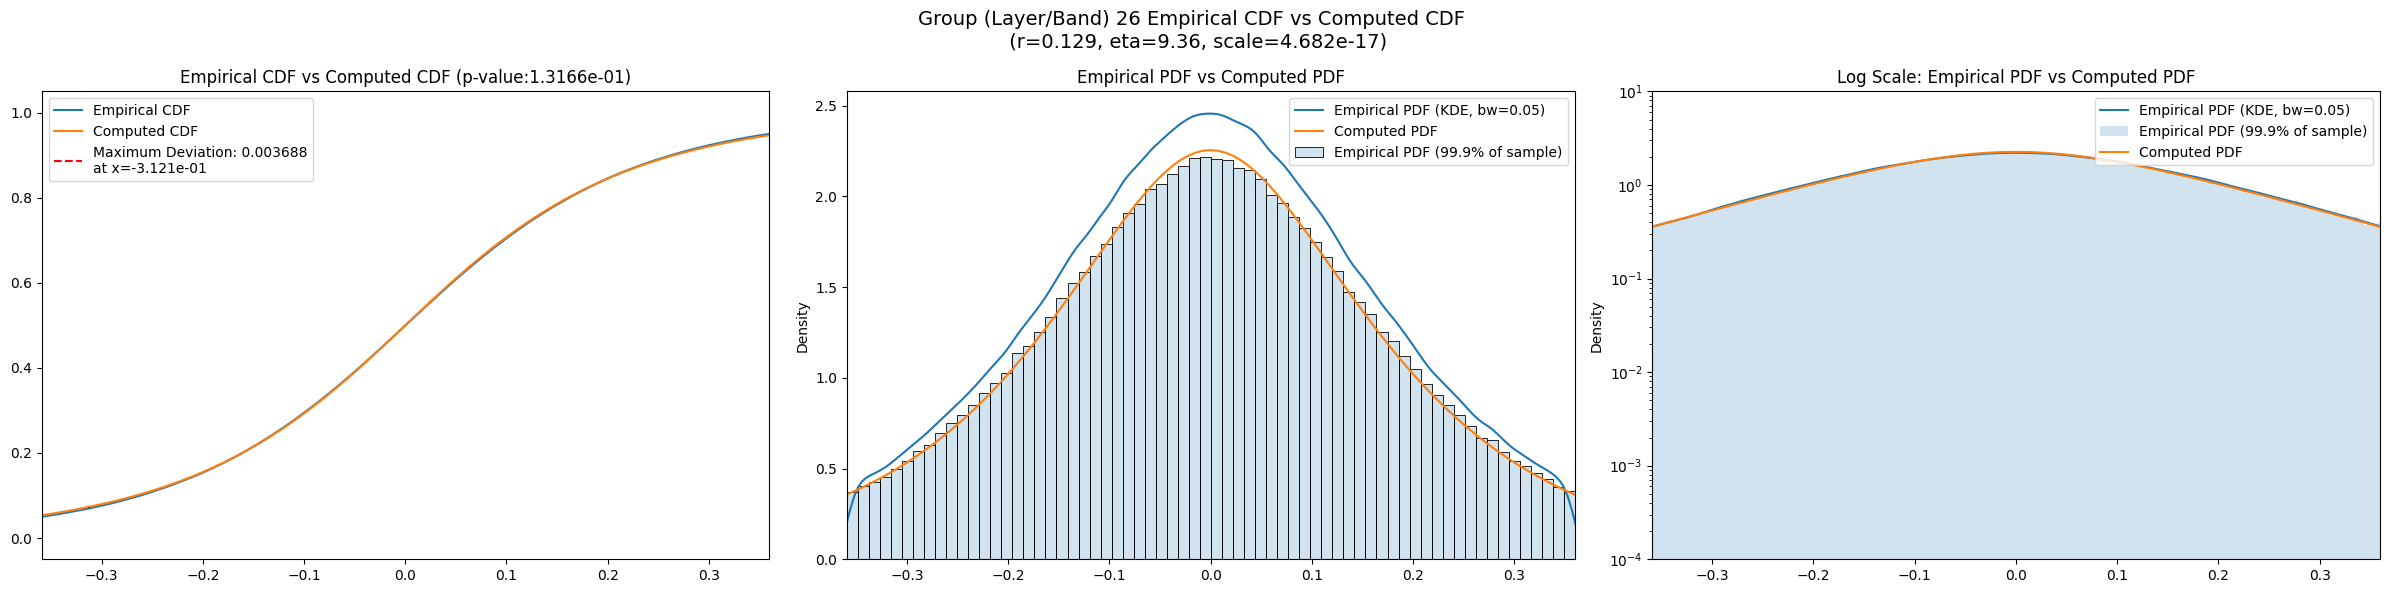

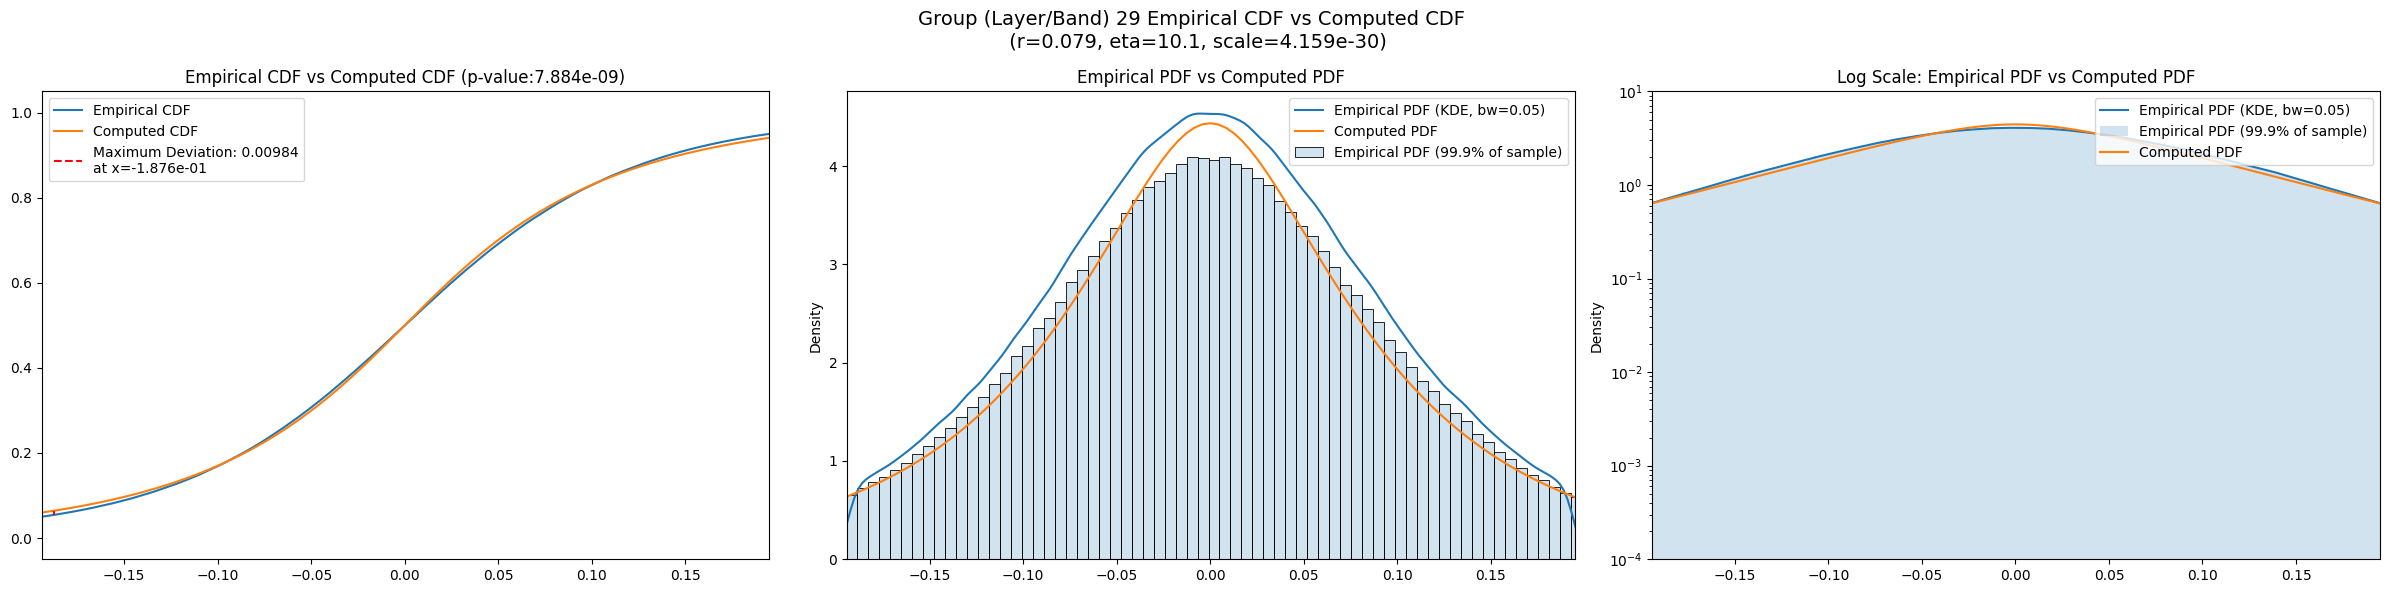

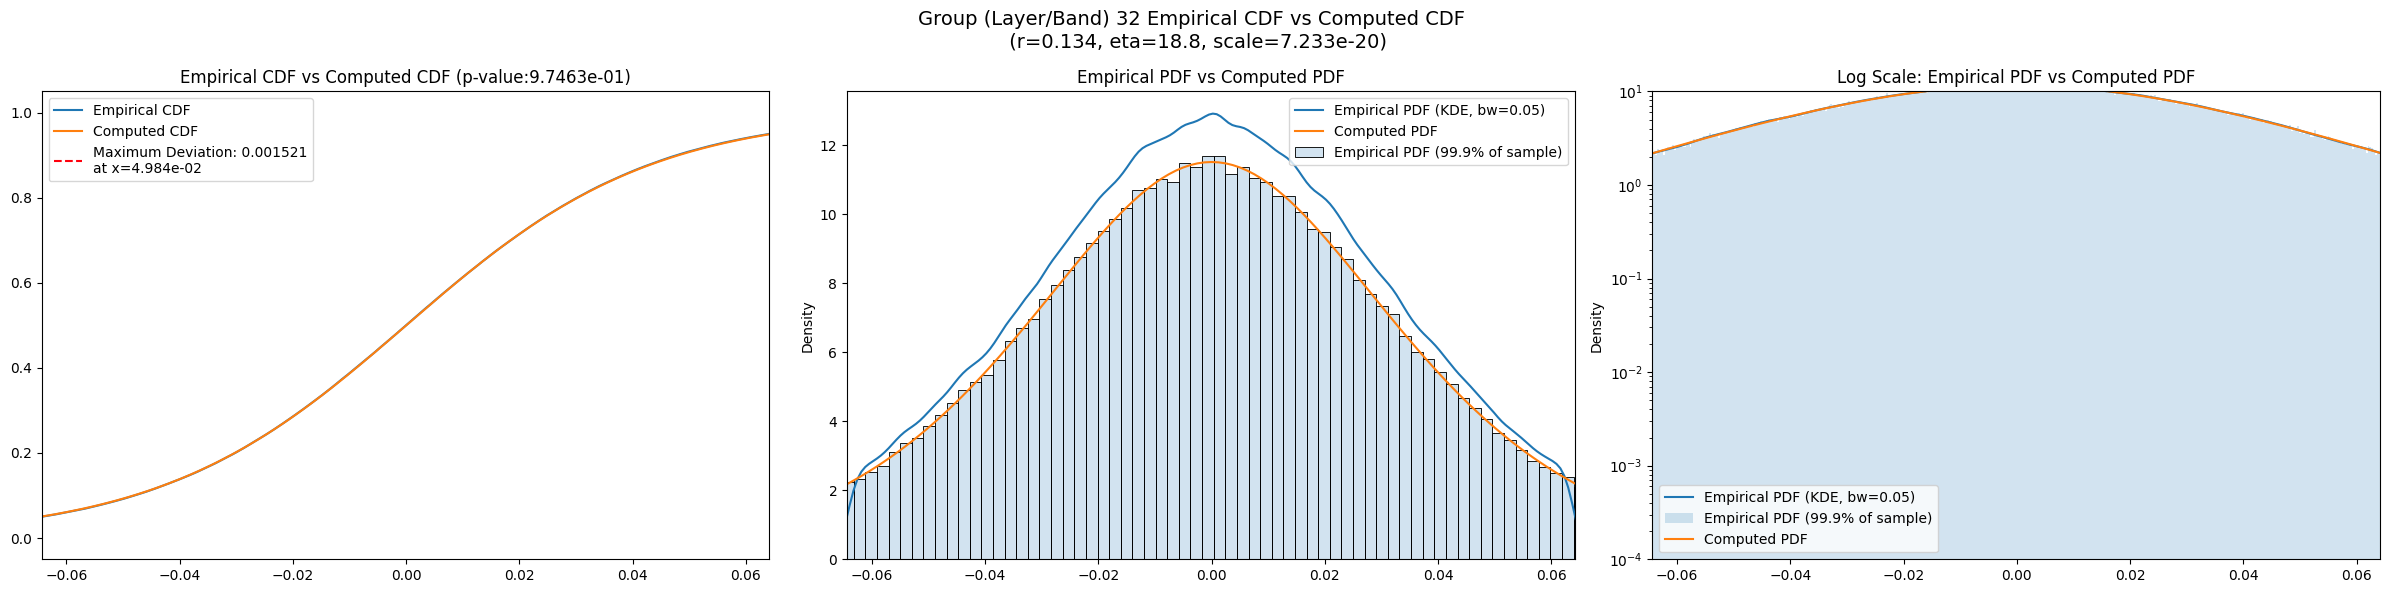

In [13]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [14]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [15]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     14.564291  13.887027  15.268839   1.329861    0.962390    1.772640   
5      7.681994   7.323771   8.055925   1.392025    0.909872    2.123118   
8      4.073018   3.884318   4.267340   1.377129    0.967720    1.917665   
11     2.242928   2.133372   2.357460   1.727334    1.042835    3.028584   
14     1.177406   1.121854   1.236006   1.563712    0.985900    3.021425   
17     0.631009   0.600541   0.662828   1.652823    1.062084    3.063314   
20     0.301410   0.286417   0.317915   2.060602    1.170981    6.707925   
23     0.134888   0.127928   0.142416   2.336577    1.422220    4.876342   
26     0.053216   0.049692   0.057507   5.787819    2.479208   17.814651   
29     0.018185   0.016213   0.021056  23.688461    6.687737   80.945920   
32     0.001581   0.001508   0.001656   1.305109    0.893868    2.017627   

      total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                        ...   
2           31800.0       0.26          8.0   1.229014e-05  ...   
5           41340.0       0.13         19.0   8.117170e-17  ...   
8           66780.0       1.04          1.2   1.638445e+00  ...   
11         104940.0       0.17         13.0   8.333795e-12  ...   
14         162180.0       0.35          5.8   1.771573e-04  ...   
17         257580.0       0.42          3.9   1.277089e-03  ...   
20         381600.0       0.23          7.7   2.735783e-08  ...   
23         610560.0       0.19          8.5   9.569363e-11  ...   
26         973080.0       0.13          9.3   6.760444e-17  ...   
29        1376940.0       0.08         10.0   1.197460e-29  ...   
32         419760.0       0.14         18.0   6.576789e-19  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           3.513690              0.012827          5.658420e-05   
5           2.573470              0.011148          6.846020e-05   
8           1.876010              0.011126          1.311160e-07   
11          1.386370              0.010774          5.215310e-11   
14          1.002840              0.011347          1.448320e-18   
17          0.729572              0.012077          4.646640e-33   
20          0.502478              0.012116          4.383640e-49   
23          0.330777              0.013546          9.711380e-98   
26          0.200854              0.014894         6.410510e-188   
29          0.108554              0.015675         2.623140e-294   
32          0.037164              0.010039          3.580570e-37   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          3.142650             0.020702         2.855970e-12  2.525700   
5          2.277990             0.020432         2.013390e-15  1.841310   
8          1.657720             0.020464         1.004910e-24  1.334620   
11         1.218570             0.019089         1.194270e-33  0.984688   
14         0.890651             0.020163         1.047670e-57  0.717145   
17         0.645618             0.018305         2.128310e-75  0.520072   
20         0.442115             0.017516        3.931640e-102  0.356538   
23         0.292966             0.017112        1.002810e-155  0.236633   
26         0.176969             0.015656        1.331490e-207  0.142909   
29         0.095421             0.015589        4.578340e-291  0.077495   
32         0.032717             0.020070        2.594580e-147  0.026428   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.022253   4.128530e-14          8.026566e-01  
5          0.022306   2.674840e-18          9.872271e-01  
8          0.021798   5.391600e-28          5.8108

## Results

In [16]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [17]:
master_df

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     14.564291  13.887027  15.268839   1.329861    0.962390    1.772640   
5      7.681994   7.323771   8.055925   1.392025    0.909872    2.123118   
8      4.073018   3.884318   4.267340   1.377129    0.967720    1.917665   
11     2.242928   2.133372   2.357460   1.727334    1.042835    3.028584   
14     1.177406   1.121854   1.236006   1.563712    0.985900    3.021425   
17     0.631009   0.600541   0.662828   1.652823    1.062084    3.063314   
20     0.301410   0.286417   0.317915   2.060602    1.170981    6.707925   
23     0.134888   0.127928   0.142416   2.336577    1.422220    4.876342   
26     0.053216   0.049692   0.057507   5.787819    2.479208   17.814651   
29     0.018185   0.016213   0.021056  23.688461    6.687737   80.945920   
32     0.001581   0.001508   0.001656   1.305109    0.893868    2.017627   

      total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                        ...   
2           31800.0       0.26          8.0   1.229014e-05  ...   
5           41340.0       0.13         19.0   8.117170e-17  ...   
8           66780.0       1.04          1.2   1.638445e+00  ...   
11         104940.0       0.17         13.0   8.333795e-12  ...   
14         162180.0       0.35          5.8   1.771573e-04  ...   
17         257580.0       0.42          3.9   1.277089e-03  ...   
20         381600.0       0.23          7.7   2.735783e-08  ...   
23         610560.0       0.19          8.5   9.569363e-11  ...   
26         973080.0       0.13          9.3   6.760444e-17  ...   
29        1376940.0       0.08         10.0   1.197460e-29  ...   
32         419760.0       0.14         18.0   6.576789e-19  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           3.513690              0.012827          5.658420e-05   
5           2.573470              0.011148          6.846020e-05   
8           1.876010              0.011126          1.311160e-07   
11          1.386370              0.010774          5.215310e-11   
14          1.002840              0.011347          1.448320e-18   
17          0.729572              0.012077          4.646640e-33   
20          0.502478              0.012116          4.383640e-49   
23          0.330777              0.013546          9.711380e-98   
26          0.200854              0.014894         6.410510e-188   
29          0.108554              0.015675         2.623140e-294   
32          0.037164              0.010039          3.580570e-37   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          3.142650             0.020702         2.855970e-12  2.525700   
5          2.277990             0.020432         2.013390e-15  1.841310   
8          1.657720             0.020464         1.004910e-24  1.334620   
11         1.218570             0.019089         1.194270e-33  0.984688   
14         0.890651             0.020163         1.047670e-57  0.717145   
17         0.645618             0.018305         2.128310e-75  0.520072   
20         0.442115             0.017516        3.931640e-102  0.356538   
23         0.292966             0.017112        1.002810e-155  0.236633   
26         0.176969             0.015656        1.331490e-207  0.142909   
29         0.095421             0.015589        4.578340e-291  0.077495   
32         0.032717             0.020070        2.594580e-147  0.026428   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.022253   4.128530e-14          8.026566e-01  
5          0.022306   2.674840e-18          9.872271e-01  
8          0.021798   5.391600e-28          5.8108

In [18]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))